## Projet P3 OC Data Scientist: Concevez une application au service de la santé publique

Lien vers les consignes du projet sur openclassrooms : https://openclassrooms.com/fr/projects/628/assignment

Lien vers la définition des variables : https://world.openfoodfacts.org/data/data-fields.txt

#### Idée d'application: calculer un nutri-rein à partir des composantes nutritionnelles prépondérantes (sodium, graisses, proteines fibres,...) pour un patient en insuffisance rénale. Le nutri-rein sera comparé aux valeurs du nutri-score de la base Open Food Facts pour évaluer sa qualité.

#### Contrairement au nutri-score, le nutri-rein sera calculé par rapport à l'apport en énergie et en nutriments journalier nécessaire à un patient en insuffisance rénale (données sur les apports énergétiques édictées par des néphrologues du CHU de Lyon), évaluant les apports nutritionnels et énergétiques des produits sur la base de 3 repas-type: petit déjeuner, repas du midi, repas du soir.

## 1. Mise en place environnement et import des librairies

In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display

import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn import decomposition
from sklearn import preprocessing
from sklearn import compose
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn import manifold
import sklearn.metrics

import os
import warnings
warnings.filterwarnings('ignore')

pd.options.mode.chained_assignment = None  # default='warn'

# Versions des librairies
print("Version librairie pandas: " + pd.__version__)
print("Version librairie numpy: " + np.__version__)
print("Version librairie matplotlib: " + matplotlib.__version__)
print("Version librairie seaborn: " + sns.__version__)

Version librairie pandas: 1.1.3
Version librairie numpy: 1.19.2
Version librairie matplotlib: 3.3.2
Version librairie seaborn: 0.11.0


In [2]:
#Modification des affichages de colonnes, lignes et largeurs de colonnes pour avoir un maximum d'information
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth', None)

In [3]:
print(os.listdir("./Input"))

['datafood_appli.csv', 'datafood_final.csv', 'en.openfoodfacts.org.products.csv']


## 2. Fonctions

In [4]:
# Analyse univariée
# Fonction qui permet l'affichage de l'histogramme dela distribution des données et des boxplot
def display_distrib(df_col, nom_col):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle('Analyse univariée de la variable: ' + nom_col)
    sns.set(font_scale=1)
    
    # Affichage diagramme de distribution (displot)
    sns.histplot(ax=axes[0],data=df_col,kde=True, bins=50)
    axes[0].set_title('Distribution de la variable: ' + nom_col + ' (displot)')
    axes[0].set(xlabel=nom_col, ylabel = "Distribution")
    
    # Affichage boîtes à moustaches (boxplot)
    plt.figure(figsize=(12,8))
    sns.boxplot(ax=axes[1],data=df_col.values,orient='h')
    axes[1].set_title('Distribution de la variable: ' + nom_col + ' (boxplot)')
    axes[1].set(xlabel=nom_col, ylabel = "Distribution")
    
    plt.show()
    return None

In [5]:
# PCA: affichage du cercle des corrélations à partir des différents plans factoriels
def affich_cercle_corr(pcs, n_comp, pca, rang_fact, labels=None, label_rotation=0, lims=None):
    f1, f2 = rang_fact
    
    # Initialisation de la figure
    plt.figure(figsize=(10,10))
    
    if f2 < n_comp:
        
        # Détermination des limites du graphique
        if lims is not None :
            xmin, xmax, ymin, ymax = lims
        elif pcs.shape[1] < 30 :
            xmin, xmax, ymin, ymax = -1, 1, -1, 1
        else :
            xmin, xmax, ymin, ymax = min(pcs[f1,:]), max(pcs[f1,:]), min(pcs[f2,:]), max(pcs[f2,:])

        # Affichage des flèches
        # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
        if pcs.shape[1] < 30 :
            plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
            pcs[f1,:], pcs[f2,:], 
            angles='xy', scale_units='xy', scale=1, color="red", linewidths=2.5)

        else:
            lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
            ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
                        
        # Affichage des noms des variables  
        if labels is not None:
            for i,(x, y) in enumerate(pcs[[f1,f2]].T):
                if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                    plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
                        
        # Affichage du cercle
        circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
        plt.gca().add_artist(circle)

        # Définition des limites du graphique
        plt.xlim(xmin, xmax)
        plt.ylim(ymin, ymax)
        
        # Affichage des lignes horizontales et verticales
        plt.plot([-1, 1], [0, 0], color='grey', ls='--')
        plt.plot([0, 0], [-1, 1], color='grey', ls='--')

        # Nom des axes, avec le pourcentage d'inertie expliqué
        sns.set(font_scale=1)
        plt.xlabel('F{} ({}%)'.format(f1+1, round(100*pca.explained_variance_ratio_[f1],1)))
        plt.ylabel('F{} ({}%)'.format(f2+1, round(100*pca.explained_variance_ratio_[f2],1)))

        sns.set(font_scale=1.5)
        plt.title("Cercle des corrélations (F{} et F{})".format(f1+1, f2+1))
        plt.show(block=False)
        
    return None

In [6]:
def calcul_pca(df_in, n_comp, eboulis_affich):
    # Préparation des données pour PCA
    df_datafood_corr_pca = df_in[['energy_100g','fat_100g','saturated-fat_100g','carbohydrates_100g',\
                                       'sugars_100g','fiber_100g','proteins_100g','sodium_100g']]
    
    data_pca = df_datafood_corr_pca.values
    names =  df_in['nutriscore_grade']
    features = df_datafood_corr_pca.columns

    # Centrage et Réduction
    #std_scale = preprocessing.StandardScaler().fit(data_pca)
    #data_pca_scaled = std_scale.transform(data_pca)
    data_pca_scaled =  preprocessing.StandardScaler().fit_transform(data_pca)

    # Calcul des composantes principales
    pca = decomposition.PCA(n_components=n_comp,svd_solver='full')
    pca.fit(data_pca_scaled)
    data_pca_projeted = pca.transform((data_pca_scaled))

    # Variance expliquée dans PCA
    print("Variance expliquée:")
    print(pca.explained_variance_ratio_)

    # Affichage du diagramme des éboulis et somme cumulée des variances des composantes de l'ACP
    if eboulis_affich == 'oui':
        plt.figure(figsize=(12,5))
        ratio_var_pca = pca.explained_variance_ratio_*100
        plt.bar(np.arange(len(ratio_var_pca))+1, ratio_var_pca)
        plt.plot(np.arange(len(ratio_var_pca))+1, ratio_var_pca.cumsum(),c="red",marker='o')
        plt.title('Diagramme des éboulis des vecteurs propres et somme cumulée de variance des composantes de l\'ACP')
        plt.xlabel('Nombre de composantes de l\'ACP')
        plt.ylabel('Ratio de variance expliquée')

    # Donnée pour affichage cercle des corrélations
    pcs = pca.components_
    print(' ')
    print("Ensemble des vecteurs propres")
    print(pcs)
    
    return data_pca, pcs, pca, features, data_pca_projeted

In [7]:
def point_plans_factoriels(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(12,8))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
            
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des {} individus sur F{} et F{}".format(X_projected.shape[0], d1+1, d2+1), fontdict=font_title)
            plt.show(block=False)

In [8]:
# Fonction principale du calcul du nutri-rein
def calcul_nutrirein(df):
    # Points N: calcul du pourcentage de graisses saturées
    df['ratio_sat_fat'] = df.apply(lambda x: calcul_ratio_graisses(x['saturated-fat_100g'], x['fat_100g']),axis=1)
    
    # Points N: calcul du score pour les graisses saturées
    list_interval_ratio_sat_fat = [0, 0.05, 0.1, 0.15, 0.2 ,0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
    df_score = calcul_score_point_n(df, 'score_sat_fat','ratio_sat_fat',list_interval_ratio_sat_fat)
    
    # Points N: calcul du score pour les graisses
    list_interval_fat = [0, 1, 1.5, 2, 3, 3.5 ,4, 5, 6, 6.5, 7]
    df_score = calcul_score_point_n(df, 'score_fat','fat_100g',list_interval_fat)
    
    # Point N: calcul du score pour les sucres
    list_interval_sugar = [0, 0.1, 0.2, 0.4, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2]
    df_score = calcul_score_point_n(df, 'score_sugar','sugars_100g',list_interval_sugar)
    
    # Points N: calcul du score pour les glucides
    list_interval_glucid = [0, 1, 3, 5, 7, 9, 11, 13, 15, 17, 20]
    df_score = calcul_score_point_n(df, 'score_glucid','carbohydrates_100g',list_interval_glucid)
    
    # Points N: calcul du score pour le sodium
    list_interval_sodium = [0, 0.01, 0.05, 0.07, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.25]
    df_score = calcul_score_point_n(df, 'score_sodium','sodium_100g',list_interval_sodium)
    
    # Points N: calcul du score pour l'apport énergétique en kj
    list_interval_energie = [0, 100, 150, 200, 300, 350, 400, 450, 500, 600, 700]
    df_score = calcul_score_point_n(df, 'score_energie','energy_100g',list_interval_energie)
    
    # Points P: calcul du score pour les fibres
    list_interval_fiber = [0, 0.5, 1, 2, 3, 2.5]
    df_score = calcul_score_point_p(df, 'score_fiber','fiber_100g',list_interval_fiber)
    
    # Points P: calcul du score pour les protéines
    list_interval_proteins = [0, 0.5, 1, 2, 3, 4.3]
    df_score = calcul_score_point_p(df, 'score_proteins','proteins_100g',list_interval_proteins)
    
    # Somme des points N sur 60
    df['score_point_n'] = df.apply(lambda row: row.score_sat_fat + row.score_fat + row.score_sugar + row.score_glucid \
                                   + row.score_sodium + row.score_energie, axis=1)
    # Somme des points P sur 20
    df['score_point_p'] = df.apply(lambda row: row.score_fiber + row.score_proteins, axis=1)
    
    # Score nutri-rein
    df['score_nutri_rein'] = df.apply(lambda row: row.score_point_n - row.score_point_p, axis=1)
    
    # Conversion du nutriscore_grade en valeurs numériques
    # Création dictionnaire des valeurs numériques du nutriscore_grade
    score_grade_num = {'a':1, 'b':2, 'c':3, 'd':4, 'e':5}
    df['nutriscore_grade_num'] = df['nutriscore_grade'].map(score_grade_num)
    
    # Calcul du grade pour le nutri-rein
    list_interval_score = [1, 25, 37, 48, 60]
    df_score = calcul_grade_nutri_rein(df, 'grade_nutri_rein', 'score_nutri_rein', list_interval_score )
    
    # Conversion du grade nutri-rein en valeurs numériques
    df['grade_nutri_rein_num'] = df['grade_nutri_rein'].map(score_grade_num)
    
    return df_score

In [9]:
# Calcul du nutri-rein: fonctions pour calculer la ratio graisses saturées sur graisses
# Fonction pour calculer le ratio graisses saturées par rapport aux graisses
def calcul_ratio_graisses(saturated_fat,fat):
    if saturated_fat == 0 or fat == 0:
        ratio = round(0,4)
    else:
        ratio = round(saturated_fat/fat,4)
    return ratio

# Calcul des points négatifs (produits ayant une faible qualité nutritionnelle)
def calcul_score_point_n(df, col_score,col_a_scorer,liste_interval):
    df[col_score] = [0 if x <= liste_interval[1]\
                           else (1 if x > liste_interval[1] and x <= liste_interval[2]\
                           else 2 if x > liste_interval[2] and x <= liste_interval[3]\
                           else 3 if x > liste_interval[3] and x <= liste_interval[4]\
                           else 4 if x > liste_interval[4] and x <= liste_interval[5]\
                           else 5 if x > liste_interval[5] and x <= liste_interval[6]\
                           else 6 if x > liste_interval[6] and x <= liste_interval[7]\
                           else 7 if x > liste_interval[7] and x <= liste_interval[8] \
                           else 8 if x > liste_interval[8] and x <= liste_interval[9] \
                           else 9 if x > liste_interval[9] and x <= liste_interval[10] \
                           else 10) for x in df[col_a_scorer]]
    return df

# Calcul des points positifs (produits ayant une bonne qualité nutritionnelle)
def calcul_score_point_p(df, col_score,col_a_scorer,liste_interval):
    df[col_score] = [0 if x <= liste_interval[1]\
                           else (1 if x > liste_interval[1] and x <= liste_interval[2]\
                           else 2 if x > liste_interval[2] and x <= liste_interval[3]\
                           else 3 if x > liste_interval[3] and x <= liste_interval[4]\
                           else 4 if x > liste_interval[4] and x <= liste_interval[5]\
                           else 5) for x in df[col_a_scorer]]
    return df

# Calcul du grade nutri-rein
def calcul_grade_nutri_rein(df, col_grade,col_score,liste_interval):
    df[col_grade] = ['a' if x <= liste_interval[0]\
                           else ('b' if x > liste_interval[0] and x <= liste_interval[1]\
                           else 'c' if x > liste_interval[1] and x <= liste_interval[2]\
                           else 'd' if x > liste_interval[2] and x <= liste_interval[3]\
                           else 'e' if x > liste_interval[3] and x <= liste_interval[4]\
                           else 'unknown') for x in df[col_score]]
    return df

In [10]:
# Affichage de la dstribution du grade d'un score sur les différents clusters
def affich_distrib_grade(df_pca, df_in, col_grade, labels_kmeans):
    df_pca['label'] = labels_kmeans
    df_pca['grade'] = df_in[col_grade]

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    fig.suptitle('Distribution des grades ' + col_grade + ' par cluster k-means')
    sns.set(font_scale=1)
    
    # Affichage diagramme de distribution (histplot) pour le cluster 0
    sns.histplot(ax=axes[0],data=df_pca[df_pca['label'] == 0]['grade'],kde=False, bins=50, binwidth=1)
    axes[0].set_title('Distribution du ' + col_grade + ' pour le cluster 0')
    axes[0].set(xlabel=col_grade, ylabel = "Nombre")
    
    # Affichage diagramme de distribution (histplot) pour le cluster 1
    sns.histplot(ax=axes[1],data=df_pca[df_pca['label'] == 1]['grade'],kde=False, bins=50, binwidth=1) 
    axes[1].set_title('Distribution du ' + col_grade + ' pour le cluster 1')
    axes[1].set(xlabel=col_grade, ylabel = "Nombre")
    
    # Affichage diagramme de distribution (histplot) pour le cluster 2
    sns.histplot(ax=axes[2],data=df_pca[df_pca['label'] == 2]['grade'],kde=False, bins=50, binwidth=1) 
    axes[2].set_title('Distribution du ' + col_grade + ' pour le cluster 2')
    axes[2].set(xlabel=col_grade, ylabel = "Nombre")
    
    
    plt.show()
    
    return None

In [11]:
# Fonction pour l'encodage du grade (nutri-score et nutri-rein) en valeur numérique
def encode_grade(df_in, col_grade, col_grade_num):
    
    # Création du mapping
    map_encodage = {"a":5,
                    "b":4,
                    "c":3,
                    "d":2,
                    "e":1,
               }

    # Remplacer la valeur catégorielle par l'encodage numérique
    df_in[col_grade_num] = df_in[col_grade].map(map_encodage)
    
    return df_in

In [12]:
# Fonction pour calcul classification T-SNE
def classif_tsne(df_in):
    
    # Pré-traitement
    # Centrage et réduction (sauf la dernière colonne: 'nutriscore_grade' ou 'grade_nutri_rein')
    std_scaler = preprocessing.StandardScaler().fit(df_in.iloc[:,:-1])
    X_std = std_scaler.transform(df_in.iloc[:,:-1])
    
    # Instantiation du T-SNE
    tsne = manifold.TSNE(n_components=2,
                     perplexity=30,
                     n_iter=300,
                     init='pca', # initialisation par PCA
                     verbose=1
                    )

    # Application du T-SNE
    X_projected = tsne.fit_transform(X_std)
    
    return X_projected

In [13]:
# Fonction pour la représentation graphique du grade nutri-score par T-SNE
def proj_grade_tsne(tsne_proj, label):
    
    plt.figure(figsize=(15,15))

    # Definitions des limites pour les axes
    plt.xlim(tsne_proj[:,0].min(), tsne_proj[:,0].max())
    plt.ylim(tsne_proj[:,1].min(), tsne_proj[:,1].max())

    # Definition du label des axes
    plt.title("t-SNE\n")
    plt.xlabel("t-SNE axe 1")
    plt.ylabel("t-SNE axe 2")

    # Définition des glyphes et de couleurs pour les grade nutri-Score
    for i in range(len(tsne_proj)):
        plt.text(tsne_proj[:,0][i], # x-coordinate
                 tsne_proj[:,1][i], # y-coordinate
                 label.iloc[i,0], # labels
                 color=plt.cm.RdYlGn(int(label.iloc[i,1])/5.)
        )

In [14]:
# Fonction pour l'affichage de graphes camembert répartition grades nutri-score et nutri-rein
def compare_nutriscore_nutri_rein(df_in, col_grade_nutriscore, col_grade_nutrirein):
    nutrigrades_score = df_in.groupby(by=col_grade_nutriscore)['code'].nunique().sort_values(ascending=False)
    nutrigrades_rein = df_in.groupby(by=col_grade_nutrirein)['code'].nunique().sort_values(ascending=False)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), subplot_kw=dict(aspect="equal"))
    fig.suptitle('Répartion des produits par grade')

    explodes = np.zeros(5)
    explodes[0] = .1

    ax1.pie(nutrigrades_score, labels=nutrigrades_score.index, 
        startangle=0, 
        shadow=True,
        explode=explodes,
        autopct='%1.1f%%',
        textprops=dict(color="black",size=12, weight="bold"))
    ax1.title.set_text('Répartition des grades Nutri-score')
        
    ax2.pie(nutrigrades_rein, labels=nutrigrades_rein.index, 
        startangle=0, 
        shadow=True,
        explode=explodes,
        autopct='%1.1f%%',
        textprops=dict(color="black",size=12, weight="bold"))
    ax2.title.set_text('Répartition des grades Nutri-rein')
    
    plt.show()
    
    return None

In [15]:
# Fonction pour l'affichage de la répartition des grades par catégorie de produits
def affich_repart_grade_categ(df_in, liste_categ, nb_categ, col_score, col_grade):
    n_col = 2
    fig, axes = plt.subplots(int(nb_categ/n_col), n_col, sharex=False, sharey=False, figsize=(21,int(3*nb_categ)))
    axes = np.array(axes)
    fig.suptitle('Distribution des scores ' + col_score + ' par catégorie de produit', fontsize=16)
    i=0
    for ax in axes.reshape(-1):
        #categ = df_in['pnns_groups_2'].unique()[i]
        categ = liste_categ[i] 
        sous_ens = df_in[df_in['pnns_groups_2']==categ].sort_values(col_grade)
        sns.histplot(data=sous_ens, x=col_score, hue=col_grade, ax=ax)
        ax.set_title('Catégorie : {}'.format(categ))
        ax.set_xlabel('Score ' + col_score)
        ax.set_ylabel("Nombre de produits")
        i+=1
    plt.show()
    
    return None

## 3. Chargement du jeu  de données

In [16]:
df_datafood = pd.read_csv('./input/datafood_final.csv', delimiter=',', encoding='utf-8', low_memory=False,  index_col=0)

In [17]:
df_datafood.shape

(85159, 23)

In [18]:
df_datafood.columns

Index(['code', 'product_name', 'quantity', 'brands', 'categories', 'labels',
       'countries', 'ingredients_text', 'nutriscore_score', 'nutriscore_grade',
       'pnns_groups_2', 'main_category', 'energy-kcal_100g', 'energy_100g',
       'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g',
       'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g',
       'nutrition-score-fr_100g'],
      dtype='object')

In [19]:
df_datafood.head(3)

,code,product_name,quantity,brands,categories,labels,countries,ingredients_text,nutriscore_score,nutriscore_grade,pnns_groups_2,main_category,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g
24,0000000001281,Tarte noix de coco,unknown,"Crous Resto',Crous","Tartes, Tartes sucrées, Tartes à la noix de coco",unknown,France,unknown,14.0,d,Biscuits and cakes,en:coconut-pies,381.0,1594.0,22.0,15.5,27.3,21.9,4.4,4.6,0.100,0.0400,14.0
34,0000000001885,Compote de poire,unknown,Crous,"Aliments et boissons à base de végétaux, Aliments d'origine végétale, Desserts, Aliments à base de fruits et de légumes, Fruits et produits dérivés, Compotes, Compotes de poire",unknown,France,unknown,-2.0,a,Fruits,en:pear-compotes,157.0,657.0,0.0,0.0,36.0,27.0,3.6,0.6,0.000,0.0000,-2.0
69,0000000005470,BAguette bressan,1,Crousresto',"Aliments et boissons à base de végétaux, Aliments d'origine végétale, Céréales et pommes de terre, Pains, Baguettes",unknown,France,"Bâguette Bressan Pain baguette 46,2%,' farine de BLÉ, eau, sel, levure, GLUTEN, farine de BLE malté, levure désactivée, acide ascorbique, Garniture 53,8%: filet de poulet braisé 34,3% (filet de poulet 82%, eau, acidifiant : lactate de potassium et acétate de sodium, amidon modifié de manioc, sel, dextrose glucose, arômes, gélifiants E407ayaM$xydant : érythèfbate de sodium, colorant : grafnel • origine UE), tomateN25x8%, OEUF dur 22,70/ , 'salade 17,20/ O",-4.0,a,Bread,en:baguettes,160.0,669.0,2.2,0.5,25.2,0.6,1.6,9.5,0.358,0.1432,-4.0


In [20]:
df_datafood.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85159 entries, 24 to 1786213
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   code                     85159 non-null  object 
 1   product_name             85159 non-null  object 
 2   quantity                 85159 non-null  object 
 3   brands                   85159 non-null  object 
 4   categories               85159 non-null  object 
 5   labels                   85159 non-null  object 
 6   countries                85159 non-null  object 
 7   ingredients_text         85159 non-null  object 
 8   nutriscore_score         85159 non-null  float64
 9   nutriscore_grade         85159 non-null  object 
 10  pnns_groups_2            85159 non-null  object 
 11  main_category            85159 non-null  object 
 12  energy-kcal_100g         85159 non-null  float64
 13  energy_100g              85159 non-null  float64
 14  fat_100g           

## 4. Analyse univariée

### 4.1 Affichage des distributions et du diagramme à moustache pour chaque variable quantitative

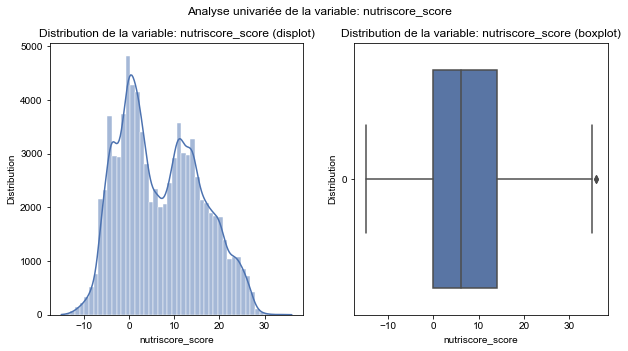

<Figure size 864x576 with 0 Axes>

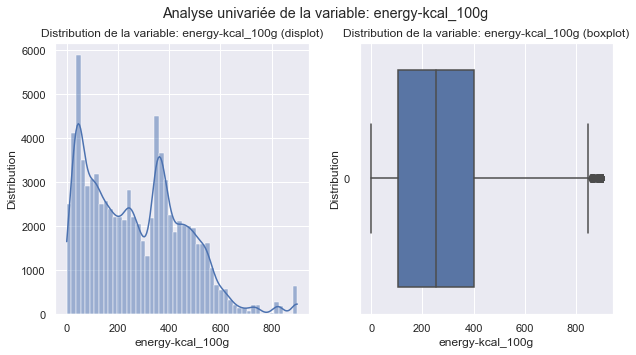

<Figure size 864x576 with 0 Axes>

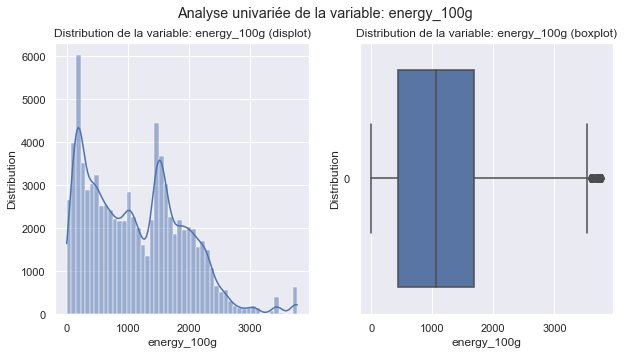

<Figure size 864x576 with 0 Axes>

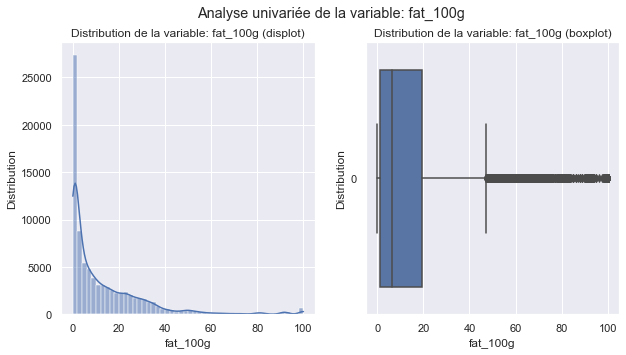

<Figure size 864x576 with 0 Axes>

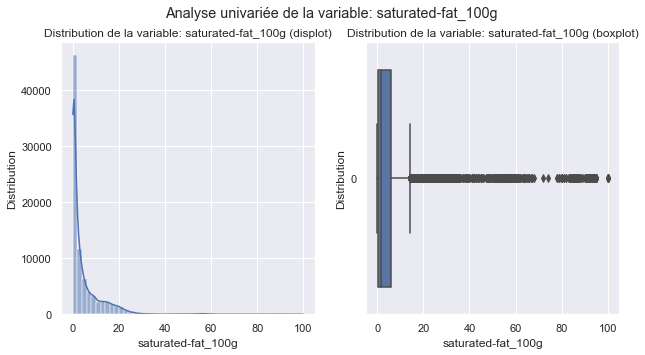

<Figure size 864x576 with 0 Axes>

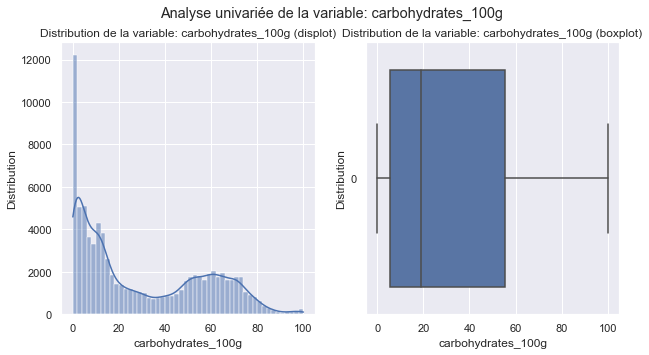

<Figure size 864x576 with 0 Axes>

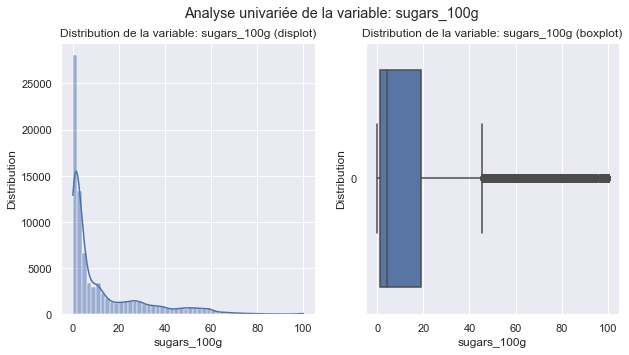

<Figure size 864x576 with 0 Axes>

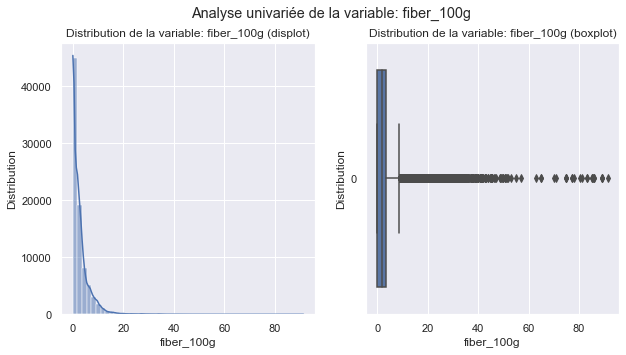

<Figure size 864x576 with 0 Axes>

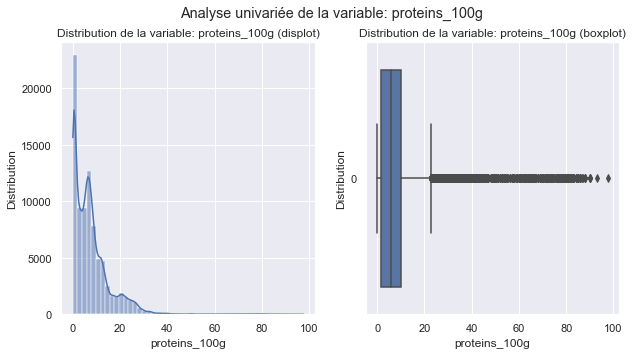

<Figure size 864x576 with 0 Axes>

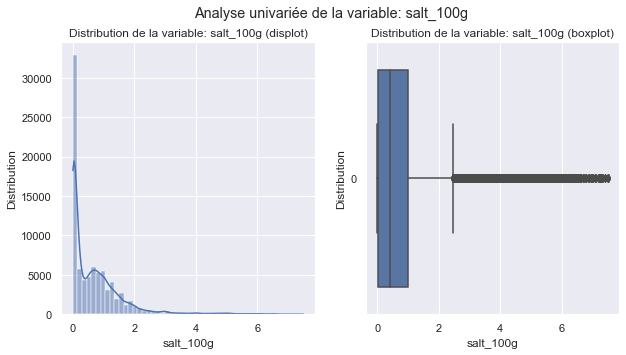

<Figure size 864x576 with 0 Axes>

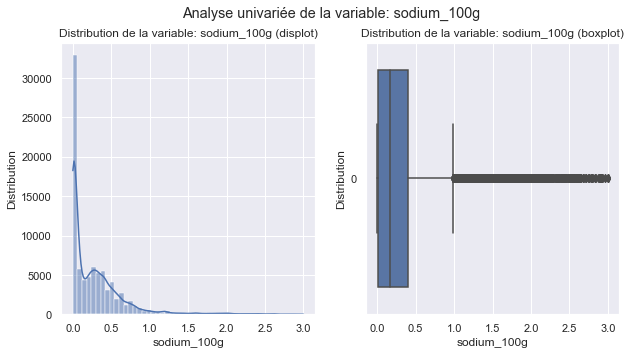

<Figure size 864x576 with 0 Axes>

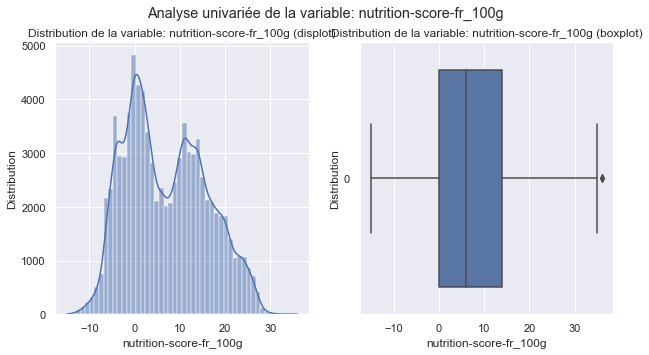

<Figure size 864x576 with 0 Axes>

In [21]:
# Appel de la fonction pour l'affichage des distributions des données
df_datafood_num = df_datafood.select_dtypes(include='float64')
for col in df_datafood_num.columns:
    display_distrib(df_datafood_num[col],col)

#### Récapitulatif de l'analyse:

#### Si on analyse les diagrammes de distribution (displot et boxplot), on remarque que les variables suivantes semblent décrire le même phénomène:
#### - les variables "nutrition-score-fr_100g" et "nutriscore_score" semblent présenter la même phénomène et la même distribution des données est bimodale réprésentant 2 phénomènes différents, d'un côté, les produits avec une bonne qualité nutritionnelle avec un mode proche de 0 et les produits avec une mauvaise qualité nutritionnelle avec un mode proche de 15
#### - de même, les variables "sodium_100g" et "salt_100g" semblent aussi représenter le même phénomène.

#### Cette similitude sera validée dans la cadre de l'analyse multivariée.

#### Par ailleurs, plusieurs variables suivent un forme de distribution semblable, à savoir un distribution asymétrique à droite:
#### fat_100g, saturated-fat_100g, sugars_100g, fiber_100g, proteins_100g, sodium_100g

#### Enfin, on se rend compte que l'échantillonnage des données est continu, ce qui rend exploitable le jeu de données. De plus, suite au traitement des outliers sur le notebook sur le nettoyage, il n'y a plus de valeurs aberrantes dans le jeu de données, seulement des valeurs atypiques. En effet:
#### - il est normal de trouver des scores supérieurs à 30, mais inférieurs à 40 pour les variables "nutriscore_score" et "nutrition-score_100g".
#### - de la même manière, il est normal d'avoir des aliments avec une teneur en sel supérieure à 2 g ou une teneur en sodium supérieure à 1 g. Exemples: le sel (39 g de sodium pour 100g), bouillon de boeuf (13 g de sodium pour 100g), moutarde, pancetta, jambon sec,...
#### - pour les apports énergétiques, on peut trouver des aliments apportant plus de 800 kcal ou 3500 kj, comme les différentes huiles (environ 900 Kcal).
#### - pour les graisses, on trouve beaucoup de produits dont la teneur en graisses ve de 50 à 100g pour 100 g de produit (amande, foie gras, beurre allégé, beurre doux, noisette, huile,...).
#### - de la même manière, pour les acides gras saturés, beaucoup de fromage sont autour de 20 g pour 100 g de produit, le beurre, la graisse de canard, le saindoux sont entre 35 et 55 g pour 100g de produit.
#### - pour les sucres, il y a beaucoup de produits dont la teneur est entre 40 et 100 de sucres pour 100 g de produit (depuis les biscuits, les chocolats, la confiture, les raisins secs, les pâtes de fruits, les chewing-gums, les bonbons, eet bien sûr le sucre !).
#### - pour les fibres, la canelle, la coriandre ont des teneurs de 50 g pour 100g de produit, le thym en contient 30g pour 100g de produit,...
#### - pour les protéines, beaucoup d'aliments contiennent plus de 30 g de protéines ppir 100g de produit, (comme le thon, les cacahuètes grilleés, le veau mijoté, viande des grisons, le parmesan et la gélatine alimentaire (90g pour 100 g de produit)).

### 4.2 Analyse des variables qualitatives

##### L'application Nutri-rein s'intéresse plus particulièreement aux apports nutritionnels pour calculer son score, par conséquent nous nous intéressons seulement aux variables qualitartives suivantes: nutri-score, catégories de produit.

#### Repartition des Nutrigrades

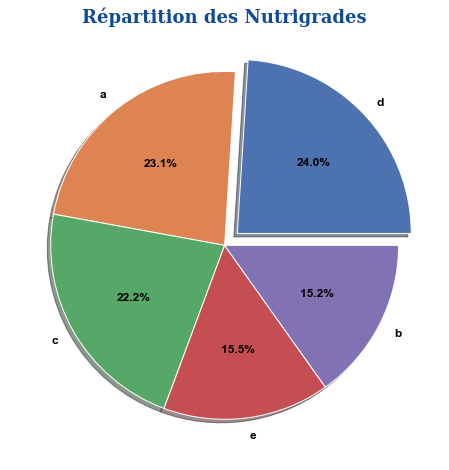

In [22]:
# Affichage de la répartition de nutrigrades
nutrigrades = df_datafood.groupby(by='nutriscore_grade')['code'].nunique().sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(aspect="equal"))

font_title = {'family': 'serif',
              'color':  '#114b98',
              'weight': 'bold',
              'size': 18,
             }

explodes = np.zeros(5)
explodes[0] = .1

plt.pie(nutrigrades, labels=nutrigrades.index, 
        startangle=0, 
        shadow=True,
        explode=explodes,
        autopct='%1.1f%%',
        textprops=dict(color="black",size=12, weight="bold"))
plt.title("Répartition des Nutrigrades", fontdict=font_title)
plt.show()

 ##### Répartition des scores Nutriscore et de leur grades

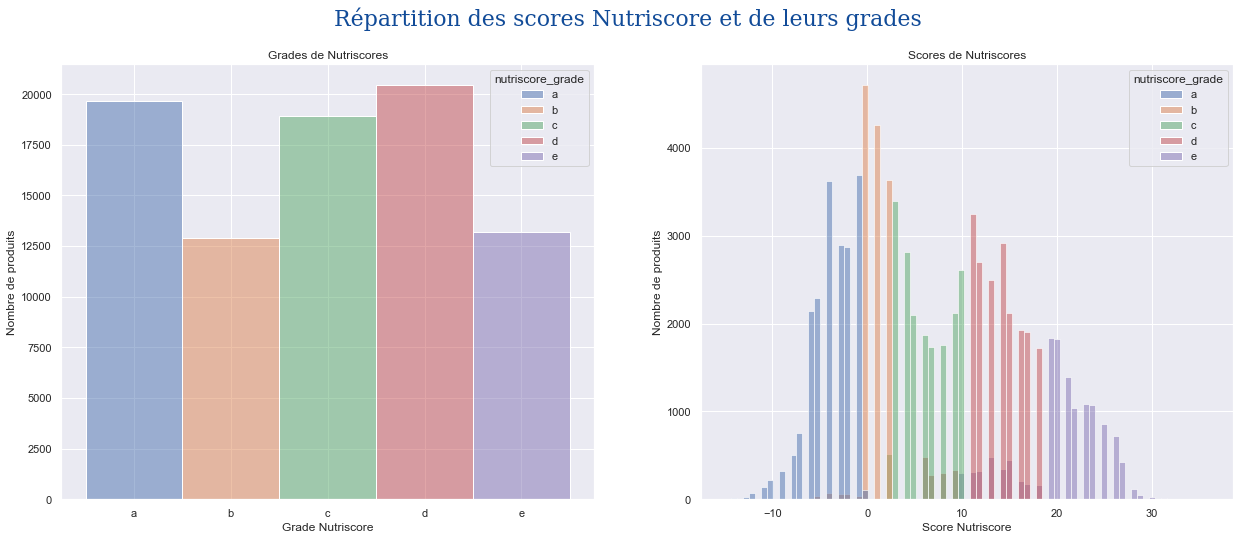

In [23]:
# Affichage de la répartition des score Nutriscore et de leurs grades
#On s'occupe ici uniquement des nutriscores et nutrigrades complétés
datas_nutri = df_datafood[(df_datafood['nutriscore_grade'].isnull()==False) & 
                   (df_datafood['nutriscore_score'].isnull()==False)]


fig, axes = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(21,8))
fig.suptitle(r"Répartition des scores Nutriscore et de leurs grades" "\n", fontdict=font_title, fontsize=22)

sns.histplot(data=datas_nutri.sort_values("nutriscore_grade"), x="nutriscore_grade", hue="nutriscore_grade", ax=axes[0])
axes[0].set_title('Grades de Nutriscores')
axes[0].set_xlabel("Grade Nutriscore")
axes[0].set_ylabel("Nombre de produits")

sns.histplot(data=datas_nutri.sort_values("nutriscore_grade"), x="nutriscore_score", hue="nutriscore_grade", ax=axes[1])
axes[1].set_title('Scores de Nutriscores')
axes[1].set_xlabel("Score Nutriscore")
axes[1].set_ylabel("Nombre de produits")

plt.show()

##### La répartition des grades Nutriscore est quasi "équi-répartie" sur les 5 grades avec tout de même une prépondérance pour la classe D. 
##### La répartition des scores Nutriscore confirme bien la distribution bimodale avec une proportion importante de produits avec des bonnes qualités nutritionnelles (grade 'a') et dans une moindre mesure les produits mauviase qualité nutritionnelle (grade 'e').

## 5. Analyse multivariée

### 5.1 Calcul et affichage de la matrice de corrélation

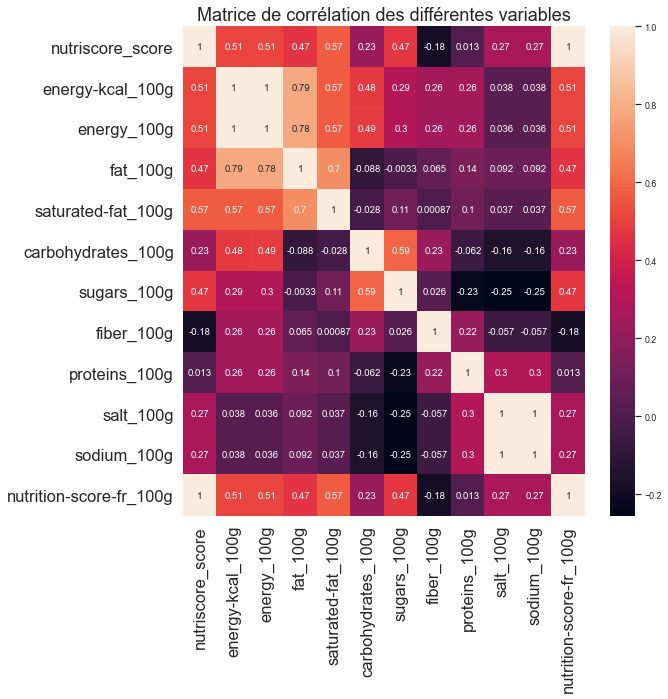

In [24]:
# Calcul et affichage matrice de corrélation
corr_matrix = df_datafood_num.corr()
fig = plt.figure(1, figsize=(9,9))
sns.set(font_scale=1.5)
plt.title('Matrice de corrélation des différentes variables')
sns.set(font_scale=0.8)
sns.heatmap(corr_matrix, annot=True)
plt.show()

#### Résultats de l'analyse multivariée:
#### - les variables "nutriscore_score" et "nutrition-score-fr_100g" sont très fortement corrélées (corr = 1).
#### - de la même manière, les variables "salt_100g" et "sodium_100g" sont très fortement corrélées (corr = 1).
#### - enfin, les variables "energy-kcal_100g" et "energy_100g" sont également très fortement corrélées (corr = 1).

#### Par conséquent, les variables "nutrition-score-fr_100g", "salt_100g" et "energy-kcal_100g" sont écartées pour le reste de l'analyse, car elles sont en doublons de variables décrivant le même phénomène.

#### On peut réduire, d'ores et déjà, le nombre de dimensions correspondant aux nutriments de 10 à 8 (élimination des variables "salt_100g" et energy-kcal_100g").

#### Autres observations:
#### - La variable énergie en kjoules (energy_100g) est corrélée (corr = 0,78) étroitement avec les graisses (fat_100g)
Cette corrélation s'explique par la fait que la première source pour l'apport d'énergie est fournie par les graisses.   

#### - Les variables fat_100g et saturated-fat_100g sont corrélées (corr = 0,7)
En effet, les graisses saturées, comme les graisses insaturées sont une sous-décomposition des graisses.
   
#### La variable sucre (sugars_100g) est corrélée (corr = 0,59) avec les glucides (carbohydrates_100g) 
En effet, les sucres simples sont les plus petits maillons de la famille des glucides.

In [25]:
# Suppression des colonnes avec corrélation à 1
df_datafood_corr = df_datafood.copy()
df_datafood_corr.drop(['nutrition-score-fr_100g', 'salt_100g', 'energy-kcal_100g'], axis=1, inplace=True)

In [26]:
df_datafood_corr.shape

(85159, 20)

In [27]:
df_datafood_corr.columns

Index(['code', 'product_name', 'quantity', 'brands', 'categories', 'labels',
       'countries', 'ingredients_text', 'nutriscore_score', 'nutriscore_grade',
       'pnns_groups_2', 'main_category', 'energy_100g', 'fat_100g',
       'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g',
       'proteins_100g', 'sodium_100g'],
      dtype='object')

In [28]:
df_datafood_corr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85159 entries, 24 to 1786213
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   code                85159 non-null  object 
 1   product_name        85159 non-null  object 
 2   quantity            85159 non-null  object 
 3   brands              85159 non-null  object 
 4   categories          85159 non-null  object 
 5   labels              85159 non-null  object 
 6   countries           85159 non-null  object 
 7   ingredients_text    85159 non-null  object 
 8   nutriscore_score    85159 non-null  float64
 9   nutriscore_grade    85159 non-null  object 
 10  pnns_groups_2       85159 non-null  object 
 11  main_category       85159 non-null  object 
 12  energy_100g         85159 non-null  float64
 13  fat_100g            85159 non-null  float64
 14  saturated-fat_100g  85159 non-null  float64
 15  carbohydrates_100g  85159 non-null  float64
 16  s

### 5.2 Réalisation d'une ACP (Analyse en Composantes Principales)

##### L'ACP permet notamment:
- l'étude et la visualisation des corrélations entre les variables, afin d'éventuellement limiter le nombre de variables à mesurer par la suite (réduction de dimensions).
- l'obtention de facteurs non corrélés qui sont des combinaisons linéaires des variables de départ, afin d'utiliser ces facteurs dans des méthodes de modélisation telles que la régression linéaire, la régression logistique ou l'analyse discriminante.
- la visualisation des observations dans un espace à deux dimensions, afin d'identifier des groupes homogènes d'observations, ou au contraire des observations atypiques.

#### 5.2.1 Cacul de l'ACP et affiichage du diagramme des éboulis

Variance expliquée:
[0.32207265 0.23662901 0.15991182 0.11183365 0.07521874 0.05374403
 0.03811274 0.00247735]
 
Ensemble des vecteurs propres
[[ 5.96052929e-01  5.14383440e-01  4.67084488e-01  2.43487937e-01
   2.09923607e-01  1.78978795e-01  1.61725787e-01  2.04872441e-02]
 [-3.79578182e-02  2.60925255e-01  1.88737102e-01 -5.39891289e-01
  -5.56836780e-01 -8.79618500e-02  3.46318932e-01  4.06978658e-01]
 [ 6.67535897e-02 -2.59412531e-01 -3.40259719e-01  2.82998037e-01
  -8.38186157e-02  6.00265299e-01  5.47954380e-01  2.54532002e-01]
 [-6.08462111e-02  1.19292635e-01  6.89185849e-02 -2.86596480e-01
  -2.89186349e-01  5.63329716e-01 -8.23382273e-02 -6.98162585e-01]
 [-1.58962908e-02  1.09604725e-01 -1.32817309e-02 -6.90928307e-03
  -8.41759520e-02  4.62658307e-01 -7.09053150e-01  5.13434807e-01]
 [-3.66859686e-01 -2.17069109e-01  4.67418986e-01 -3.64785494e-01
   5.95146798e-01  2.59402613e-01  1.65164869e-01  1.34078880e-01]
 [-1.31390931e-01 -4.29676446e-01  6.37799824e-01  4.402726

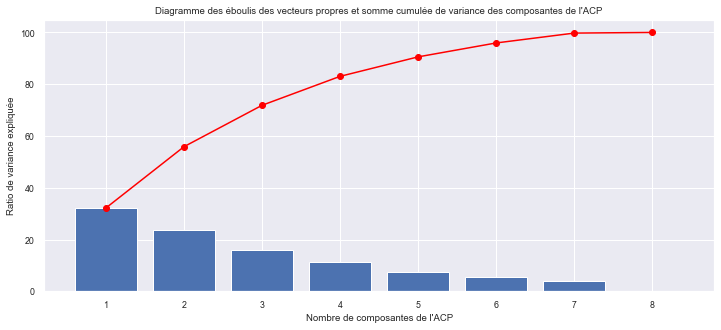

In [29]:
# Appel de la fontion de calcul de la PCA
data_pca, pcs, pca, features, data_pca_projeted = calcul_pca(df_datafood_corr, 8, 'oui')

In [30]:
# Cumul de la variance expliquée sur 2 premiers plans factoriels
varexpl = pca.explained_variance_ratio_*100
print("Le premier plan factoriel couvrira une inertie de {:.2f}% et le second plan : {:.2f}%.".format(varexpl[0:2].sum(),
                                                                                                     varexpl[0:4].sum()))

Le premier plan factoriel couvrira une inertie de 55.87% et le second plan : 83.04%.


##### Il apparaît sur la diagramme d'éboulis qu'il serait envisageable de réduire le jeu de données à 6 dimensions (variance cumulée de plus de 95 %), voire à 4 dimensions (en effet les 2 premiers plans factoriels couvre un inertie de plus de 83 %).

##### Une analyse sur  F1/F2 et F3/F4 semble donc cohérente.

#### 5.2.2 Affichage du cercle de corrélations sur les 2 premiers plans factoriels

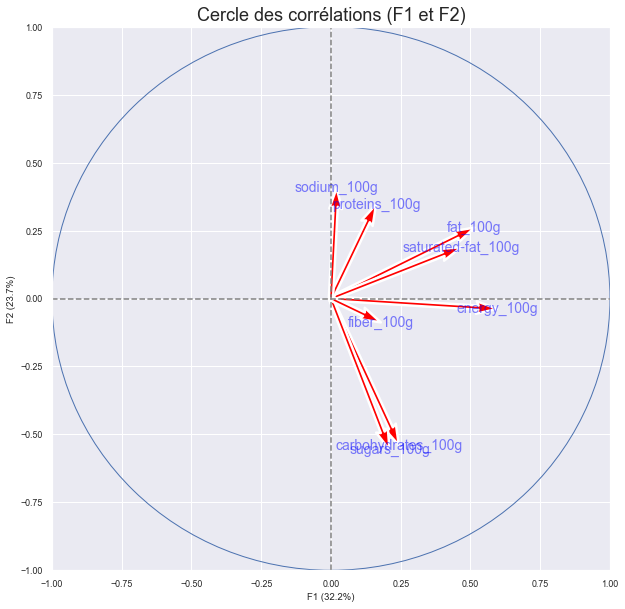

In [31]:
# Cercle des corrélations pour le premier plan factoriel
affich_cercle_corr(pcs,data_pca.shape[1], pca, (0,1), labels = np.array(features))

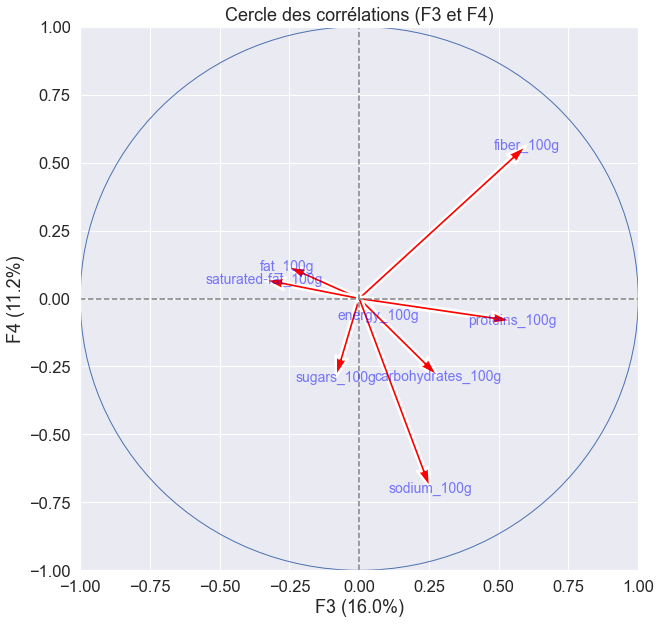

In [32]:
# Cercle des corrélations pour le premier plan factoriel
affich_cercle_corr(pcs,data_pca.shape[1], pca, (2,3), labels = np.array(features))

#### Interprétation du cercle des corrélations sur le premier plan factoriel:

#### Les variables les plus corrélées à F1 sont:
   - fat_100g
   - saturated-fat_100g
   - energy_100g

#### et elles sont corrélées positivement.

#### Si on veut interpréter F1, cela ressemble aux sources des apports énérgétiques et notamment les lipides dans ce cas.

#### On remarque aussi que les dimensions fat_100g et saturated-fat_100g sont fortement corrélées car les graisses saturées font partie de la famillle des graisses

#### Les variables les plus corrélées à F2 sont:
 - sugars_100g
 - carbohydrates_100g

#### et elles sont corrélées négativement.

#### On remarque que les dimensions sugars_100g et carbohydrates_100g sont fortement corrélées car les glucides représentent la grande famille des "sucres".

#### Difficulté pour interpréter ce que signifie F2, à ce stade de l'analyse.

#### Enfin, on se rend compte que la dimensions fiber_100g  est mal représentée (flèches courtes).


#### 5.2.3  Qualité de représentation de la réduction de dimension (COS² et CTR)

##### 5.2.3.1 Calcul de la qualité de représentation des variables (COS²)
#### On calcule la qualité de représentation des variables (COS²) en élevant la corrélation au carré. 

In [33]:
#Espace des composantes principales
pcs = pca.components_

#Matrice des corrélations variables x facteurs
p = data_pca.shape[1]
sqrt_valprop = np.sqrt(pca.explained_variance_)
corvar = np.zeros((p, p))
for dim in range(p):
    corvar[:,dim] = pcs[dim,:] * sqrt_valprop[dim]

#on affiche pour les deux premiers plans factoriels 
corr_matrix = pd.DataFrame({'feature':features,'CORR_F1':corvar[:,0],'CORR_F2':corvar[:,1], 
              'CORR_F3':corvar[:,2], 'CORR_F4':corvar[:,3]})
corr_matrix

,feature,CORR_F1,CORR_F2,CORR_F3,CORR_F4
0,energy_100g,0.956774,-0.052226,0.075503,-0.057553
1,fat_100g,0.825679,0.359003,-0.293413,0.112836
2,saturated-fat_100g,0.749756,0.259680,-0.384856,0.065188
3,carbohydrates_100g,0.390843,-0.742827,0.320089,-0.271084
4,sugars_100g,0.336966,-0.766142,-0.094804,-0.273534
5,fiber_100g,0.287294,-0.121025,0.678939,0.532840
6,proteins_100g,0.259599,0.476494,0.619772,-0.077882
7,sodium_100g,0.032886,0.559955,0.287892,-0.660375


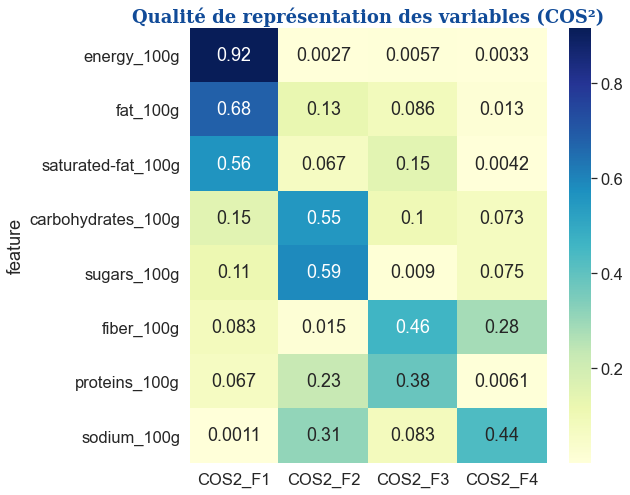

In [34]:
# Calcul des COS²
cos2var = corvar**2
df_cos2var = pd.DataFrame({'feature':features,'COS2_F1':cos2var[:,0],
                           'COS2_F2':cos2var[:,1], 'COS2_F3':cos2var[:,2],
                           'COS2_F4':cos2var[:,3]}).set_index('feature')

# Affichage dans un heatmap seaborn
fig = plt.figure(figsize=(8,8))
sns.heatmap(df_cos2var, annot=True, cmap="YlGnBu")
plt.title("Qualité de représentation des variables (COS²)", fontdict=font_title)
plt.show()

#####  5.2.3.2 Contribution des variables aux axes (CTR)
###### La CTR aussi également basée sur le carré de la corrélation, mais relativisée par l’importance de l’axe.

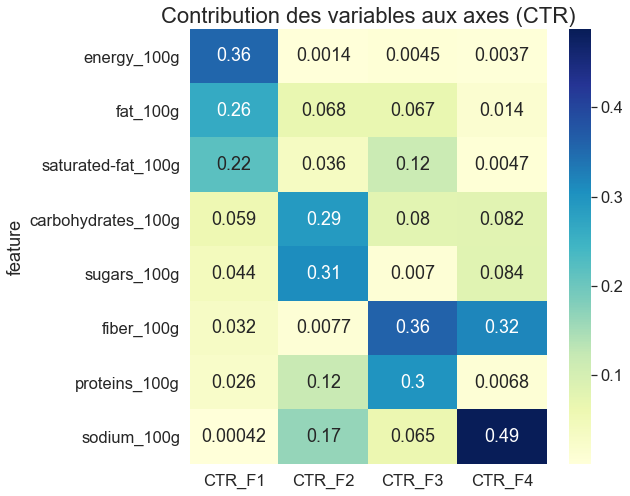

In [35]:
# Contribution des variables aux axes (CTR) 
ctrvar = cos2var 
for k in range(p): 
    ctrvar[:,k] = ctrvar[:,k]/pca.explained_variance_[k] 

df_ctrvar = pd.DataFrame({'feature':features,'CTR_F1':ctrvar[:,0],'CTR_F2':ctrvar[:,1],
                         'CTR_F3':ctrvar[:,2], 'CTR_F4':ctrvar[:,3]}).set_index('feature')

#affichage dans un heatmap seaborn
fig = plt.figure(figsize=(8,8))
sns.heatmap(df_ctrvar, annot=True, cmap="YlGnBu")
plt.title("Contribution des variables aux axes (CTR)", fontsize=22)
plt.show()

##### Les calculs du COS² et de la CTR confirment les constatations observées sur le cercle des corrélations pour l'axe F1. 
##### Ainsi, on remarque ici clairement, avec le cercle et le COS², les corrélations importantes entre l'energie et la teneur en graisses des produits sur l'axe F1.  Par conséquent, l'axe F1 représente bien le facteur "apport en énergie".

##### Par ailleurs, l'axe F2 représente bien les produits sucrés (avec une forte teneur en sucres et glucides). Cela correspond à des produits plutôt néfastes pour la santé.

##### Par ailleurs, l'axe F3 représente bien les produits riches en fibres et protéines. Cela correspond à des produits plutôt bénéfiques pour la santé.

##### Enfin, l'axe  F4 représente bien les produits riches en sodium. Comme pour l'axe F2, cela correspond à des produits plutôt néfastes pour la santé.

#### 5.2.4 Conclusion sur l'ACP

##### Dans le cadre de notre application de calcul d'un score nutri-rein, la réduction dimensionnelle n'est pas pertinente. En effet, le nettoyage initial des données a déjà permis de réduire considérablement le nombre de variables du dataset (au nombre de 8 nutriments).

##### La réduction de dimensions de 8 varibles à 6, voire à 4 variables n'est pas souhaitable.

##### Par contre, nous allons projeter les produits pour les grades Nutri-score et Nutri-rein pour essayer d'identifier des groupes de produits similaires selon leur grade.

## 6. Calcul du nutri-rein

##### Un patient en insuffisance rénale est un patient dont le débit de filtration glomérulaire (DFG) est inférieur à 60 mL/min/1.73m2. Il représente la quantité de liquide filtrée par les reins. Il se mesure grâce à la créatinine.

##### Un patient est considéré en insuffisance modérée quand son DFG est en 30 et 40.
##### Un patient est en insuffisance rénale sévère lorsque son DFG est entre 15 et 30.
##### Une dialyse est envisagée lorque le DFG est inférieur à 15.

##### Le patient en insuffisance rénale doit limiter ses apports en sodium, en calcium, phosphores, potassium et en proteines essentiellement.

### 6.1 Rappels sur les besoins en nutriments d'un insuffisant rénal

#### Quelques rappels sur les besoins spécifiques en nutriments pour un insuffisant rénal:
**- apport en sodium (en g/jour): pas plus de 3g de sodium par jour**

*Pour info, l'OMS recommande un apport de moins de 5 g par jour pour une personne sans pathologie rénale*

**- apport énégétique (en kj/kg de poids corporel/jour: environ 146 kj/kg/jour pour une personne exerçant une activité moyenne**, soit environ un apport énergétique de 80x146 = 11680 kj par jour pour une personne de 80kg. Ce chiffre est à majorer ou à minorer selon l'âge et l'activité de l'individu.

*Pour info, l'Anses préconise un apport énergétique de 8400 kj pour un femme adulte avec une activité moyenne, et de 11300 kj pour un homme adulte avec une activité moyenne, sans pathologie rénale.*

**- apport en protéines (en g/kg de poids corporel/jour): pas plus de 0,8g/kg/jour**, soit environ un apport en protéines de 80*0,8 = 64g par jour pour une personne de 80 kg.

*Pour info, les hommes et les femmes sédentaires sans pathologie rénale ont besoin d’environ 0,8 g / kg. Un entraînement en endurance fait grimper cette quantité à 1,2 – 1,4 g / kg / jour. Un entraînement en force la fait passer à 1,2 – 1,8 g / kg / jour.*

**- apport en fibres (en g/jour): au moins 30g/jour avec plus de 50% d'aliments végétaux.**

*Pour info, l'OMS recommande un apport en fibres journalier entre 25 g et 29 g jour.*

**- apport en glucides (exprimé en % de l'apport énergétique total journalier): pas plus de 50% de l'apport énergétique total journalier)**

*Par exemple, pour une personne de 80kg, on ne dépassera pas 5840 kj par jour, soit 308 g de glucides par jour.*
*Pour info, 1g de glucides = 17 kj.*

**- apport en lipides (graisses dont graisses saturées) (exprimé en % de l'apport énergétique total journalier):pas plus de 40% de l'apport énergétique total journalier, dont au moins 50 % de graisses insaturées.**

*Par exemple, pour une personne de 80 kg, on ne dépassera pas 4672 kj par jour, soit 90g de lipides par jour.*
*Pour info, 1 g de lipides = 37 kj.*

**- apport en sucres (en g/jour): pas plus de 25 g par jour.**


### 6.2 Principes du calcul du nutri-rein

**Pré-requis:**
- apport énergétique de référence (AER) pour un adulte-type de 80 kg (soit 11700 kj). En effet, l'insuffisant réal est plutôt un homme.
- le petit déjeuner se décompose en 4 ingrédients (boisson chaude + 3 ingrédients dont boisson froide évetuellement).
- les repas de midi et du soir se décomposent en 4 ingrédients (boisson, entrée, plat principal, dessert).
- soit 12 produits en tout dans une journée et on considère que les différents plats ont la même importance, par conséquent chaque plat ne doit pas dépasser 1/12 soit 8,3 % de l'apport journalier d'un adulte-type:
- ainsi pour le sodium, la teneur ne doit pas dépasser 0,25 g par produit.
- ainsi pour l'apport énergétique en kj, la teneur ne doit pas dépasser 700 kj.
- ainsi pour les glucides, la teneur ne doit pas dépasser 350 kj, soit 20 g.
- ainsi pour les sucres, la teneur ne doit pas dépasser 2 g.
- ainsi pour les graisses, la teneur totale en graisses ne doit pas dépasser 280 kj, soit 7,5 g.
- ainsi pour les graisses saturées, la teneur doit être inférieure à 50% des graisses totales.
- ainsi, pour les fibres, la teneur doit être au moins de 2,5 g. (on ne prend pas en compte des 50 % en aliments végétaux. 
- ainsi, pour les protéines, la teneur doit être au moins de 4,3 g.

#### Calcul des points négatifs (point N): 
##### Contrairement au nutri-score, il n'y a pas de distinction dans le calcul entre les boissons et les éléments solides

|Point N|energy_100g(kj)|sodium_100g(g)|carbohydrates_100g(g)|sugars_100g(g)|fat_100g(g)|saturated_fat(% fat)|
|-------|-----------|-----------|-------------|--------------|-------------|---------------|
|0|<= 100 kj |<= 0.01 g|<= 1 g|<= 0 g|<= 1 g|<= 5 % fat_100g|
|1|> 100 kj|> 0.01 g|> 1 g|> 0.1 g|> 1 g|> 5 % fat_100g|
|2|> 150 kj|> 0.05 g|> 3 g|> 0.2 g|> 1.5 g|> 10 % fat_100g|
|3|> 200 kj|> 0.07 g|> 5 g|> 0.4 g|> 2 g|> 15 % fat_100g|
|4|> 300 kj|> 0.1 g|> 7 g|> 0.8 g|> 3 g|> 20 % fat_100g|
|5|> 350 kj|> 0.12 g|> 9 g|> 1 g|> 3.5 g|> 25 % fat_100g|
|6|> 400 kj|> 0.14 g|> 11 g|> 1.2 g|> 4 g|> 30 % fat_100g|
|7|> 450 kj|> 0.16 g|> 13 g|> 1.4 g|> 5 g|> 35 % fat_100g|
|8|> 500 kj|> 0.18 g|> 15 g|> 1.6 g|> 6 g|> 40 % fat_100g|
|9|> 600 kj|> 0.20 g|> 17 g|> 1.8 g|> 6.5 g|> 45 % fat_100g|
|10|> 700 kj|> 0.25 g|> 20 g|> 2 g|> 7.5 g|> 50 % fat_100g|


#### Calcul des points positifs (point P):

|Point P|fibers_100g(g)|proteins_100g(g)|
|-------|-----------|-----------|
|0|> 0 g |> 0 g|
|1|> 0.5 g|> 0.5 g|
|2|> 1 g|> 1 g|
|3|> 1.5 g |> 2 g|
|4|> 2 g|> 3 g|
|5|> 2.5 g|> 4.3 g|


##### Le calcul du score Nutri-rein permet d'affecter un score de -10 (produits de bonne qualité nutritionnelle) à + 60 (produits de mauvaise qualité nutritionnelle).

##### Les grades Nutri-rein sont répartis de la manière suivante:
 - grade a: score de -10 à 1
 - grade b: score de 2 à 25
 - grade c: score de 26 à 37
 - grade d: score de 38 à 48
 - grade e: score de 49 à 60

In [36]:
# Appel fonction principale pour le calcul du nutri_rein
df_nutrirein = calcul_nutrirein(df_datafood_corr)

## 7. Identification de groupes de produits similaires

### 7.1 Projection des produits sur les plans factoriels (espace ACP)

##### On va essayer de  visualiser la projection des produits sur les 2 premiers plans factoriels et donc en 2D afin d'identifier des regroupements de produits par rapport aux grades Nutri-score et aux grades Nutri-Rein.

#### 7.1.1 Projection des individus (produits) par rapport au nutriscore-grade

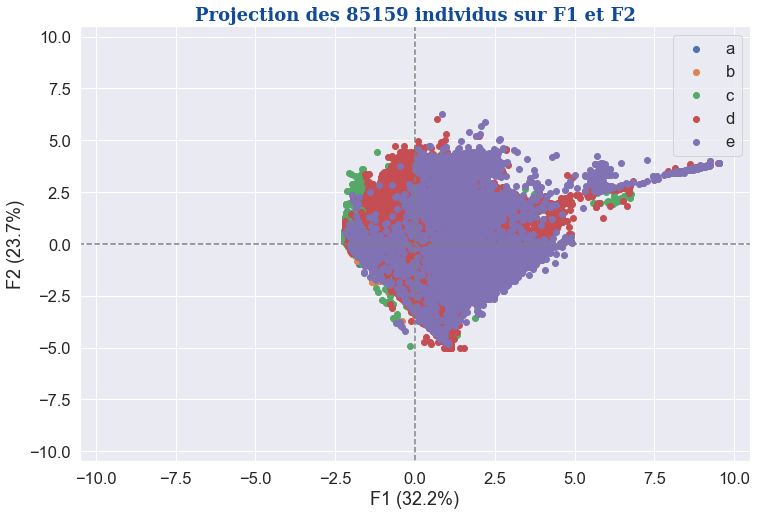

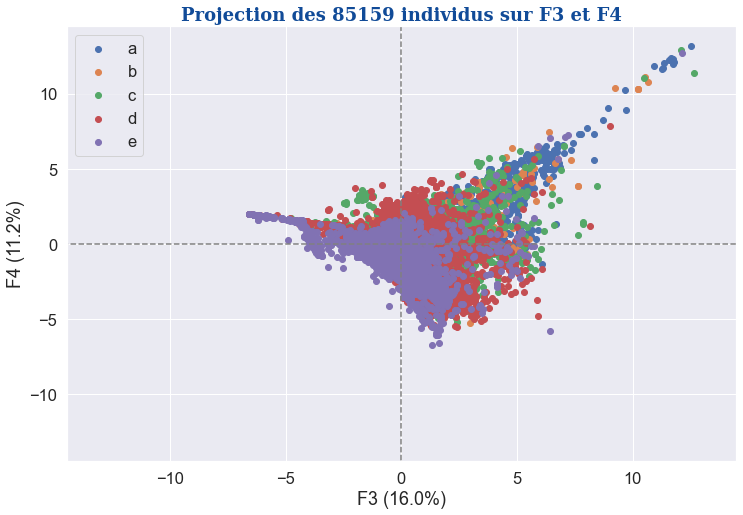

In [37]:
# Projection des individus sur le 2 premiers plans factoriels pour le nutriscore-grade actuel
grade = df_nutrirein['nutriscore_grade'].values
point_plans_factoriels(data_pca_projeted, 5, pca, [(0,1),(2,3)], illustrative_var = grade)

#### 7.1.2 Projection des individus (produits) par rapport au grade nutri-rein (suite au calcul du nutri-rein)

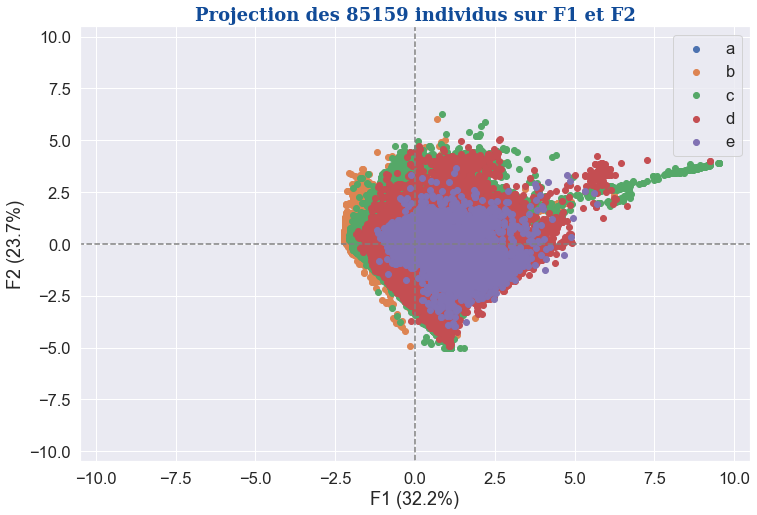

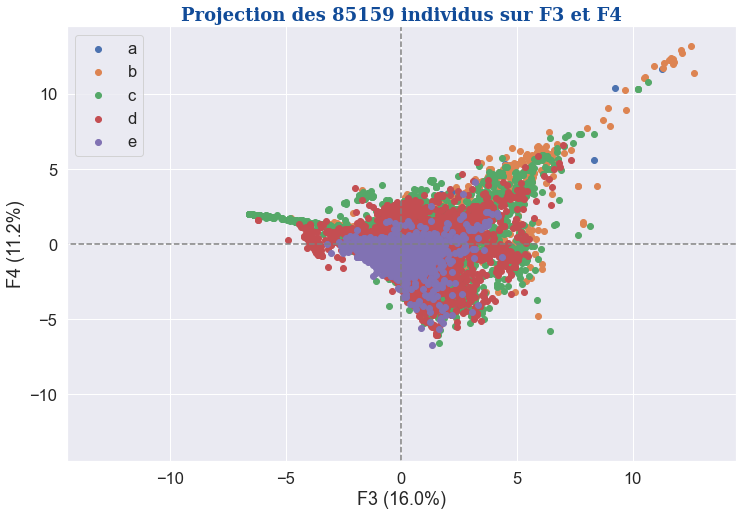

In [38]:
# Projection des individus sur le 2 premiers plans factoriels pour le grade nutri-rein
grade = df_nutrirein['grade_nutri_rein'].values
point_plans_factoriels(data_pca_projeted, 5, pca, [(0,1),(2,3)], illustrative_var = grade)

#####  La projection des produits dans l'espace ACP (PCA) ne montre pas de classification "naturelle" des produits selon leur qualité nutritionnelle en fonction du nutri-score et/ou du nutri-rein.

### 7.2 Clustering k-means

##### Application de l'algorithme k-means à partir des données transformées suite à l'ACP

#### 7.2.1 Détermination du nombre de cluster k

In [39]:
# Mise en place d'une dataframe à partir des données transformmées lors de l'opération d'ACP
df_pca_df = pd.DataFrame(data=data_pca_projeted)

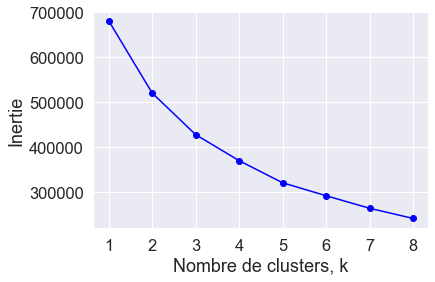

In [40]:
# K-means: détermination du nombre du clusters (détermination du coude)
ks = range(1, 9)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k)
    
    model.fit(df_pca_df.iloc[:,:9])
    
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='blue')
plt.xlabel('Nombre de clusters, k')
plt.ylabel('Inertie')
plt.xticks(ks)
plt.show()

##### La détermination du nombre de clusters n'est pas évidente, il n'y a pas de "coude" visible. La valeur 3 semble la plus pertinente.

#### 7.2.1 Lancement algorithme k-means avec nombre de cluster k = 3

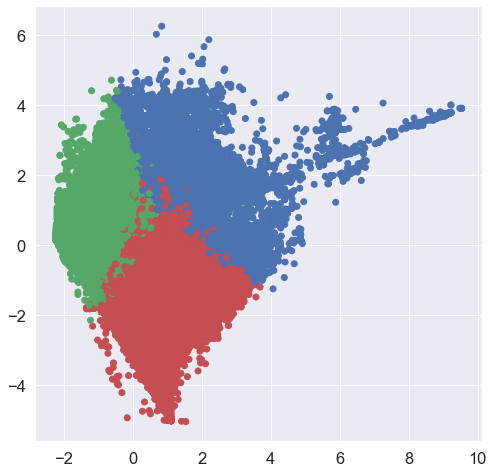

In [41]:
# Classification k-means avec k = 3
model = KMeans(n_clusters=3)
model.fit(df_pca_df.iloc[:,:6])

plt.figure(figsize=(8,8))
labels = model.predict(df_pca_df.iloc[:,:6])

label_color_map = {0 : 'r',
                   1 : 'g',
                   2 : 'b'
                   }

label_color = [label_color_map[l] for l in labels]

plt.scatter(df_pca_df[0], df_pca_df[1], c=label_color)
plt.show()

##### L'affichage des points sur les 3 clusters du k-means ne permet pas en l'état d'identifier clairement les regroupements de produits .
##### A présent, il faut afficher la distribution des grades (nutri-score et nutri-rein) par cluster pour identifier et valider les groupes de produits du nutri-rein et du du nutri-score.

#### 7.2.2 Affichage de la distribution des grades par cluster

##### 7.2.2.1 Affichage de la distribution des grades nutri-score par cluster

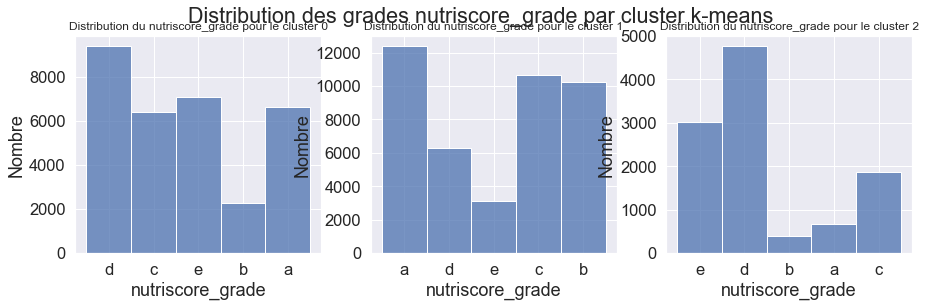

In [42]:
# Ré-initialisation des index de la dataframe df_nutrirein
df_nutrirein = df_nutrirein.reset_index(drop=True)

# Appel de la fonction pour l'affichage de la distribution des grades nutri-score par cluster k-means
affich_distrib_grade(df_pca_df, df_nutrirein, 'nutriscore_grade', labels)

##### 7.2.2.2 Affichage de la distribution des grades nutri-rein par cluster

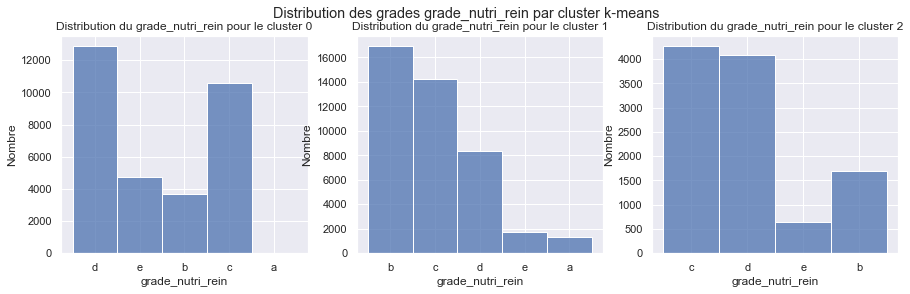

In [43]:
# Appel de la fonction pour l'affichage de la distribution des grades nutri-rein par cluster k-means
affich_distrib_grade(df_pca_df, df_nutrirein, 'grade_nutri_rein', labels)

##### Pour les grades du nutri-score, toutes les valeurs du grade sont représentées dans les 3 clusters, mais les clusters ne permettent pas de grouper les produits selon leur qualité nutritionnelle ("bons" et "mauvais" produits), puisque tous les grades sont présents dans le 3 clusters.

##### Pour les grades du nutri-rein, le grade 'a' n'est pas présent dans le cluster 1, et comme pour le grade nutri-score, les clusters ne permettent pas de classer les produits selon leur qualité nutritionnelle.

##### Par conséquent, il apparaît que le regroupement des produits par k-means ne permet pas d'identifier des groupes de produits selon leur qualité nutritionnelle.

##### Nous allons tenter de faire une réduction de dimensions avec t-SNE afin de visualiser le nuage de points et d'identiifer des groupes de produits homogènes. .

### 7.3 Réduction de dimensions avec t-SNE

#####  t-SNE est une technique de réduction de dimensions. 

##### Contrairement à la PCA, t-SNE peut être appliqué et mieux fonctionner avec des ensembles de données linéaires et non linéaires bien regroupés et  proposer des regroupements de produits plus significatifs.

##### Nous allons tenter de visualiser des groupes de produits bien séparés et homogènes avec t-SNE.

#### 7.3.1 Visualisation des produits par grade nutri-score avec t-SNE

In [44]:
# Appel de la fonction pour l'encodage des grades (nutri-score et nutri-rein)
df_nutrirein = encode_grade(df_nutrirein, 'nutriscore_grade', 'nutriscore_grade_num')

In [45]:
# Sélection de variables pour le t-SNE
# Sélection des variables numériques
sous_ens = list(df_nutrirein.select_dtypes(include=['float64']).columns)

# Suppression des colonnes "nutriscore_score" et "ratio_sat_fat"
sous_ens.remove('nutriscore_score')
sous_ens.remove('ratio_sat_fat')

# Ajout de la colonne 'nutriscore_grade', comme label
sous_ens.append('nutriscore_grade')

# Sélection uniquement des variables essentielles pour le t-SNE
X = df_nutrirein[sous_ens]
X['nutriscore_grade_num'] = df_nutrirein['nutriscore_grade_num']
X = X[['energy_100g','fat_100g','saturated-fat_100g','carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g',\
       'sodium_100g', 'nutriscore_grade_num', 'nutriscore_grade']]

# Définition des labels
label = X[['nutriscore_grade', 'nutriscore_grade_num']]

In [46]:
# Appel de la fonction pour application t-SNE
tsne_projected = classif_tsne(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 85159 samples in 0.301s...
[t-SNE] Computed neighbors for 85159 samples in 17.020s...
[t-SNE] Computed conditional probabilities for sample 1000 / 85159
[t-SNE] Computed conditional probabilities for sample 2000 / 85159
[t-SNE] Computed conditional probabilities for sample 3000 / 85159
[t-SNE] Computed conditional probabilities for sample 4000 / 85159
[t-SNE] Computed conditional probabilities for sample 5000 / 85159
[t-SNE] Computed conditional probabilities for sample 6000 / 85159
[t-SNE] Computed conditional probabilities for sample 7000 / 85159
[t-SNE] Computed conditional probabilities for sample 8000 / 85159
[t-SNE] Computed conditional probabilities for sample 9000 / 85159
[t-SNE] Computed conditional probabilities for sample 10000 / 85159
[t-SNE] Computed conditional probabilities for sample 11000 / 85159
[t-SNE] Computed conditional probabilities for sample 12000 / 85159
[t-SNE] Computed conditional probabilities for sa

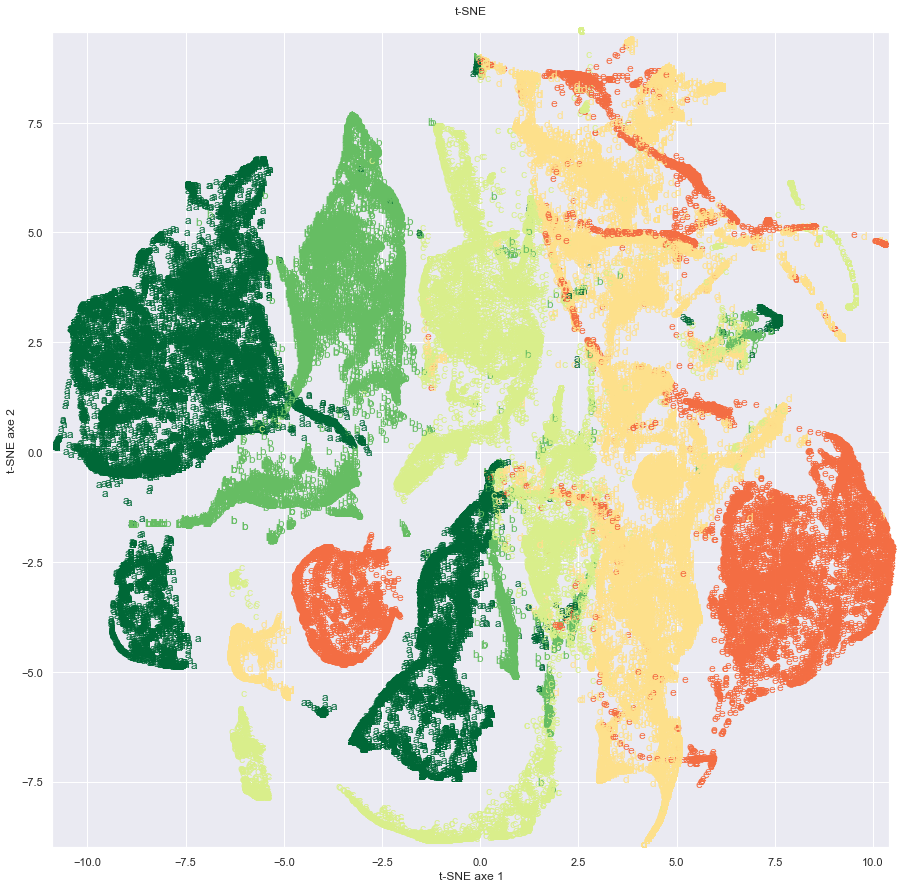

In [47]:
# Appel de la fonction pour l'affichage de la classification t-SNE
proj_grade_tsne(tsne_projected, label)

#### 7.3.2 Visualisation des produits par grade nutri-rein avec t-SNE

In [48]:
# Appel de la fonction pour l'encodage des grades (nutri-score et nutri-rein)
df_nutrirein = encode_grade(df_nutrirein, 'grade_nutri_rein', 'grade_nutri_rein_num')

In [49]:
# Sélection de variables pour le t-SNE
# Sélection des variables numériques
sous_ens = list(df_nutrirein.select_dtypes(include=['float64']).columns)

# Suppression des colonnes "nutriscore_score" et "ratio_sat_fat"
sous_ens.remove('nutriscore_score')
sous_ens.remove('ratio_sat_fat')

# Ajout de la colonne 'nutriscore_grade', comme label
sous_ens.append('grade_nutri_rein')

# Sélection uniquement des variables essentielles pour le t-SNE
X = df_nutrirein[sous_ens]
X['grade_nutri_rein_num'] = df_nutrirein['grade_nutri_rein_num']
X = X[['energy_100g','fat_100g','saturated-fat_100g','carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g',\
       'sodium_100g', 'grade_nutri_rein_num', 'grade_nutri_rein']]

# Définition des labels
label = X[['grade_nutri_rein', 'grade_nutri_rein_num']]

In [50]:
# Appel de la fonction pour application t-SNE
tsne_projected = classif_tsne(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 85159 samples in 0.314s...
[t-SNE] Computed neighbors for 85159 samples in 17.245s...
[t-SNE] Computed conditional probabilities for sample 1000 / 85159
[t-SNE] Computed conditional probabilities for sample 2000 / 85159
[t-SNE] Computed conditional probabilities for sample 3000 / 85159
[t-SNE] Computed conditional probabilities for sample 4000 / 85159
[t-SNE] Computed conditional probabilities for sample 5000 / 85159
[t-SNE] Computed conditional probabilities for sample 6000 / 85159
[t-SNE] Computed conditional probabilities for sample 7000 / 85159
[t-SNE] Computed conditional probabilities for sample 8000 / 85159
[t-SNE] Computed conditional probabilities for sample 9000 / 85159
[t-SNE] Computed conditional probabilities for sample 10000 / 85159
[t-SNE] Computed conditional probabilities for sample 11000 / 85159
[t-SNE] Computed conditional probabilities for sample 12000 / 85159
[t-SNE] Computed conditional probabilities for sa

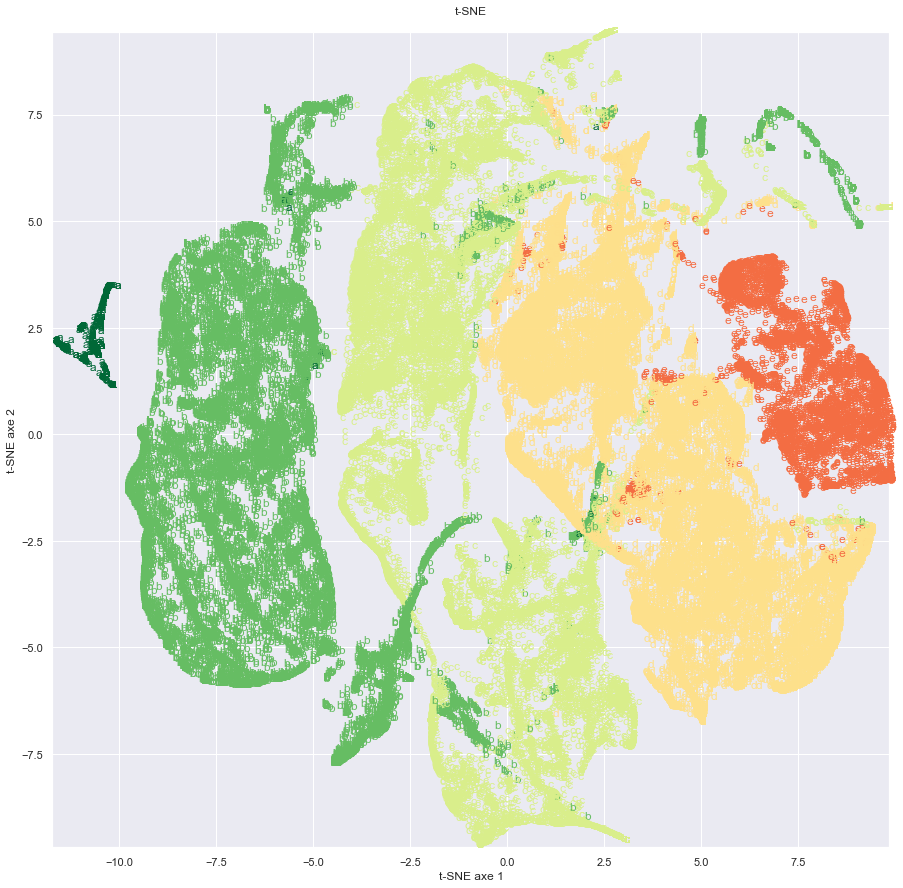

In [51]:
# Appel de la fonction pour l'affichage de la classification t-SNE
proj_grade_tsne(tsne_projected, label)

##### Conclusion sur le nuage des points affiché grâce à t-SNE:
 - l'application du t-SNE montre que les produits sont bien regroupés en groupes bien séparés correspondant aux différents grades du nutri-rein. 
 
 - par contre, pour le nutri-score, le regroupement est beaucoup moins évident, notamment pour les produits avec un grade 'a' ou 'e' qui sont disséminés dans plusieurs sous-groupes.
 
##### Ainsi, le nutri-rein semble proposer un score plus pertinant que le nutri-score pour représenter une distribution cohérente des produits selon leur qualité nutritionnelle.

## 8. Comparaisons nutri-score / nutri-rein

##### Affichage de la répartition des grades Nutri-score / Nutri-rein

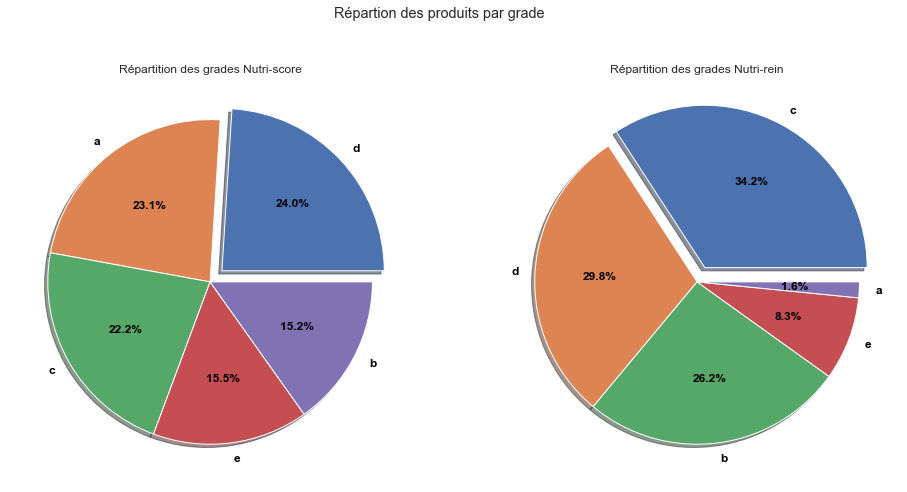

In [52]:
# Appel de la fonction pour comparer répartition des produits par nutri-score / nutri-rein
compare_nutriscore_nutri_rein(df_nutrirein, 'nutriscore_grade', 'grade_nutri_rein')

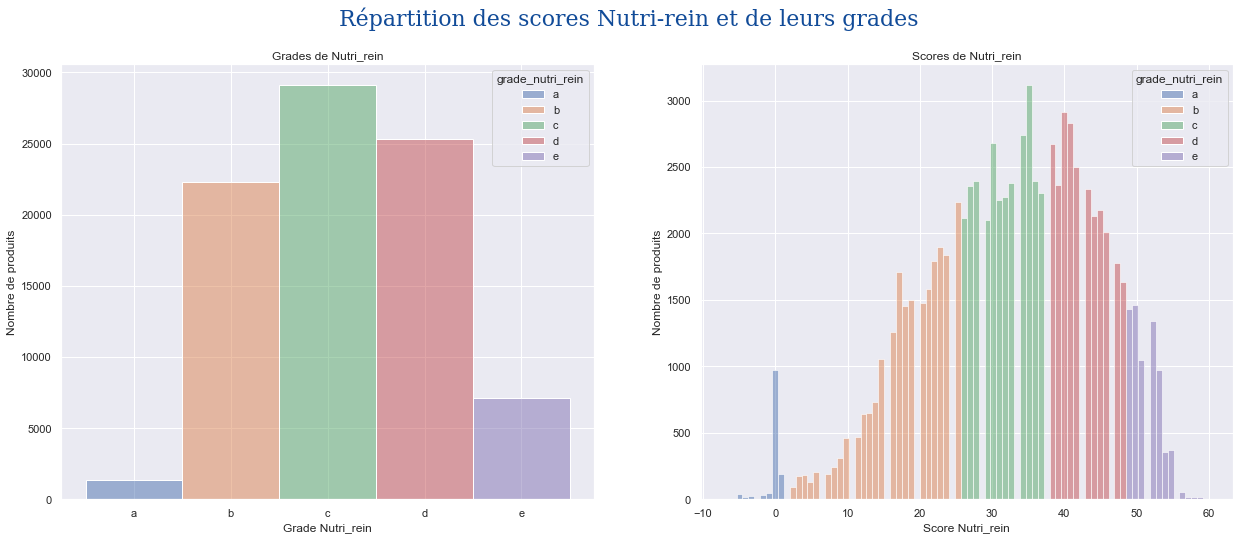

In [53]:
# Affichage de la répartition des score Nutri_rein et de leurs grades
#On s'occupe ici uniquement des scores nutri_rein et grades complétés
datas_nutri = df_nutrirein[(df_nutrirein['grade_nutri_rein'].isnull()==False) & 
                   (df_nutrirein['score_nutri_rein'].isnull()==False)]


fig, axes = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(21,8))
fig.suptitle(r"Répartition des scores Nutri-rein et de leurs grades" "\n", fontdict=font_title, fontsize=22)

sns.histplot(data=datas_nutri.sort_values("grade_nutri_rein"), x="grade_nutri_rein", hue="grade_nutri_rein", ax=axes[0])
axes[0].set_title('Grades de Nutri_rein')
axes[0].set_xlabel("Grade Nutri_rein")
axes[0].set_ylabel("Nombre de produits")

sns.histplot(data=datas_nutri.sort_values("grade_nutri_rein"), x="score_nutri_rein", hue="grade_nutri_rein", ax=axes[1])
axes[1].set_title('Scores de Nutri_rein')
axes[1].set_xlabel("Score Nutri_rein")
axes[1].set_ylabel("Nombre de produits")

plt.show()

##### La répartition des grades Nutri-score semble quelque peu "equi-répartie" entre les différents grades, ce qui peut sembler inattendu. En effet, on s'attendait à trouver une distribution normale avec une prépondérence des produits de qualité nutritionnelle moyenne (grade 'c'), et peu de produits avec une très bonne qualité nutritionnelle (grade 'a') et avec avec une très mauvaise qualité nutritionnelle.

##### La répartition des grades Nutri-rein tient compte des apports nutritionnels attendus (par produit) dans le cadre d'un produit entrant dans la composition d'un repas et s'approche plus d'une distribution normale avec une prépondérance des produits de qualité nutritionnelle moyenne (grade 'c') et peu de produit avec des grades 'a' et 'e'.

##### La répartition des grades Nutri-rein est plus réaliste pour évaluer la qualité nutritionnelle des produits que la répartition des grades Nutri-score.

##### Affichage de la répartition des grades Nutri-score / Nutri-rein par catégorie de produit

In [54]:
# Liste des catégories de produits
liste_categ_prod = ['Biscuits and cakes', 'Bread', 'Sweets', 'Salty and fatty products', 'Fish and seafood',\
                   'Cheese', 'Appetizers', 'Soups', 'Meat', 'Cereals']

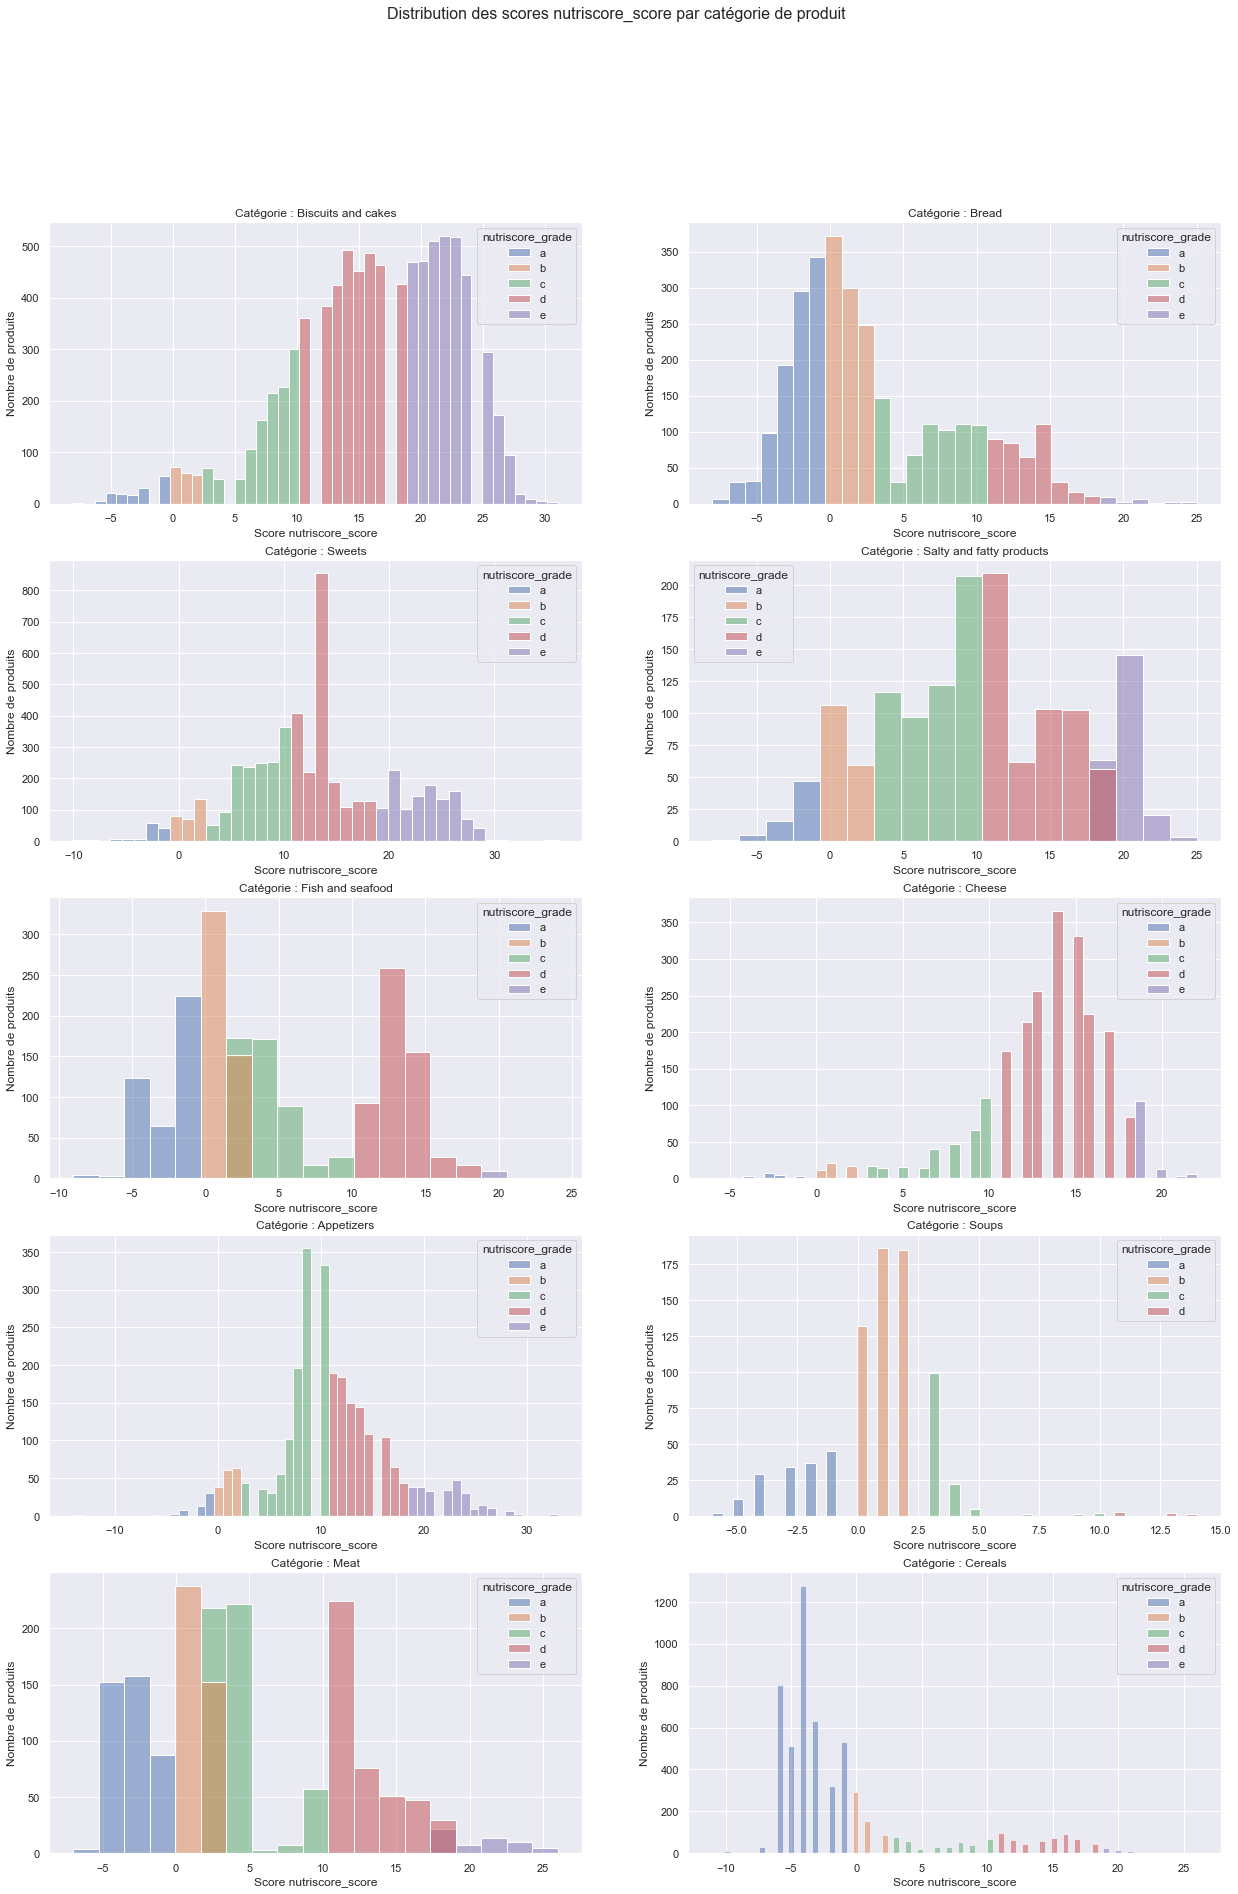

In [55]:
# Appel de la fonction pour l'affichage de la répartition des Nutri-score par catégorie de produit
affich_repart_grade_categ(df_nutrirein, liste_categ_prod, 10, 'nutriscore_score', 'nutriscore_grade')

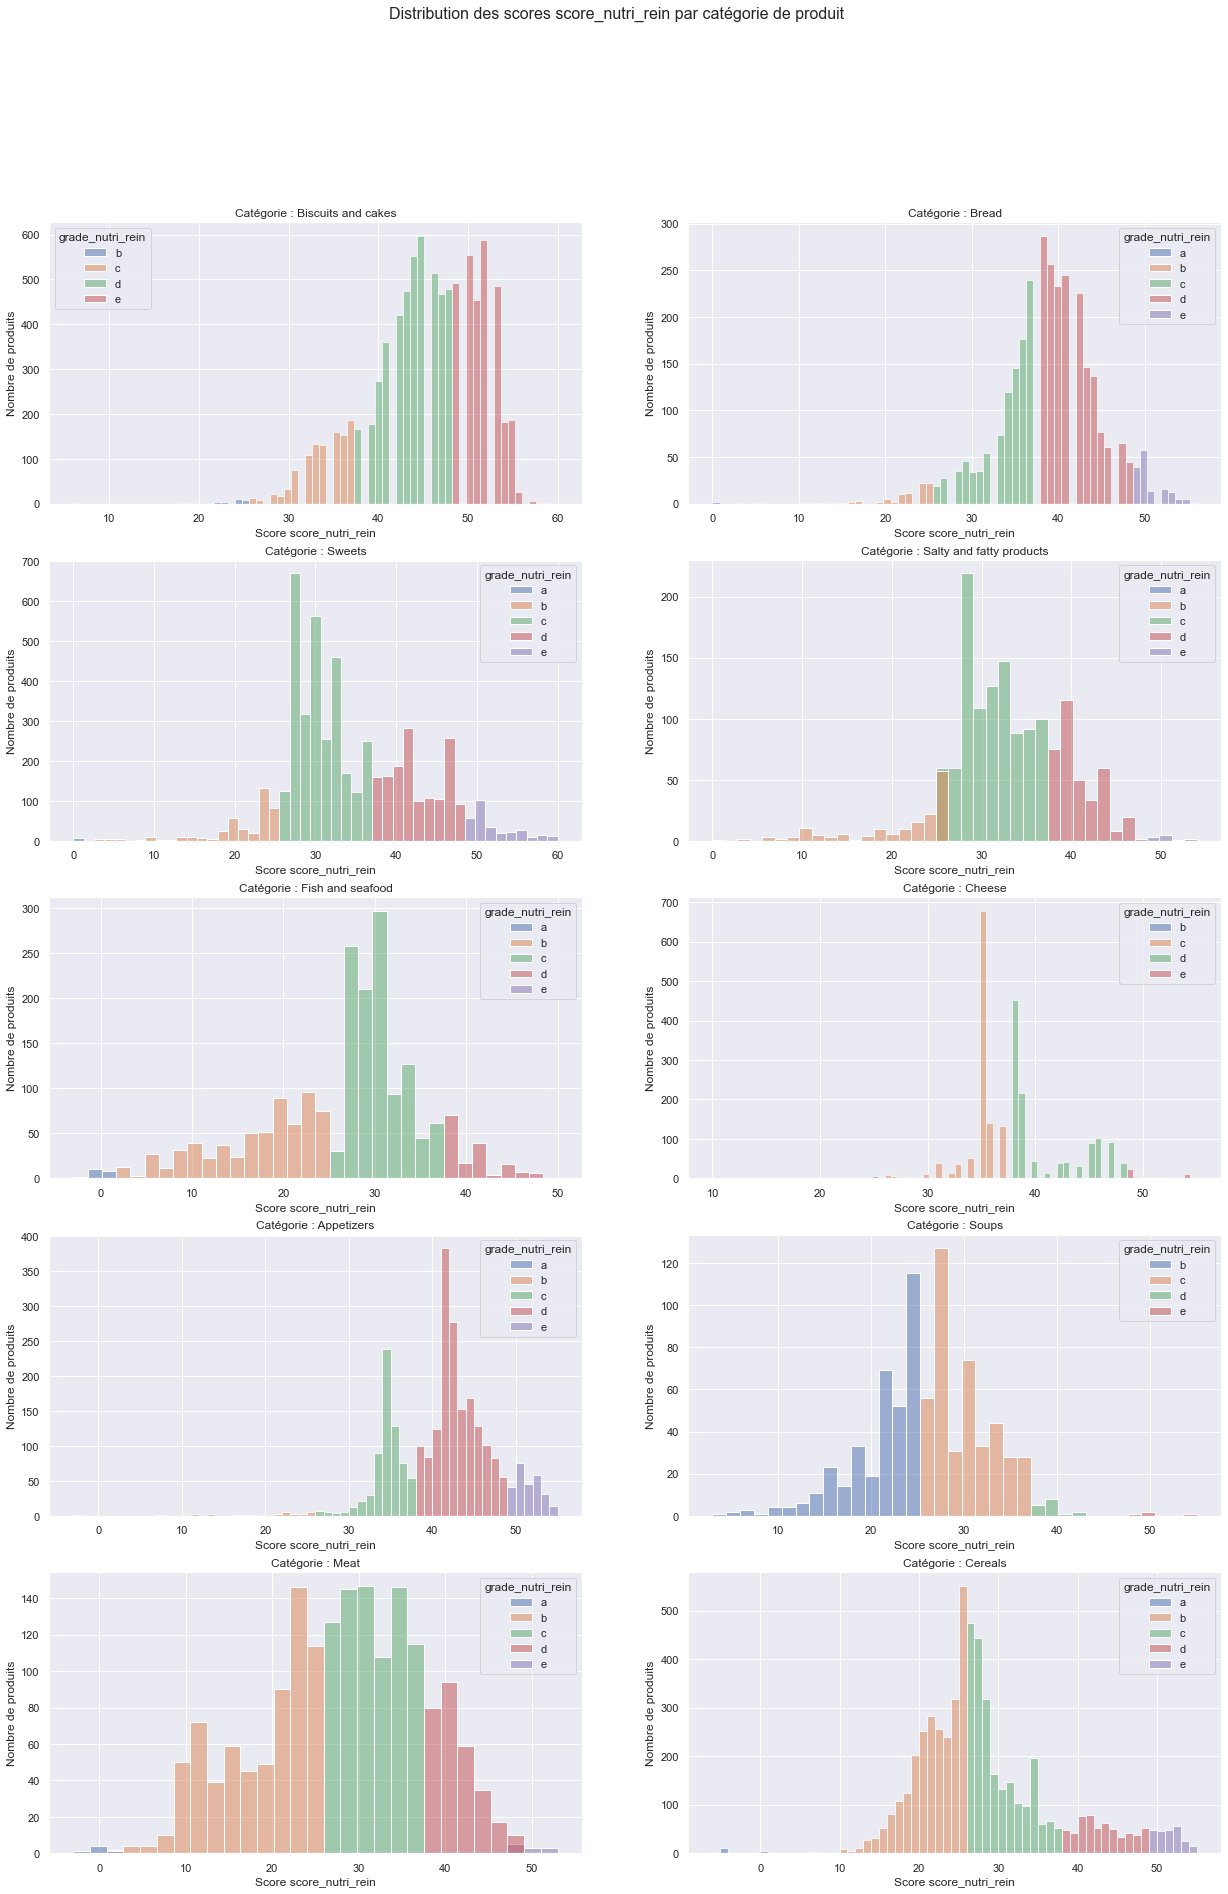

In [56]:
# Appel de la fonction pour l'affichage de la répartition des Nutri-rein par catégorie de produit
affich_repart_grade_categ(df_nutrirein, liste_categ_prod, 10, 'score_nutri_rein', 'grade_nutri_rein')

##### Si on regarde plus en détail la répartittion des grades Nutri-score et des grades Nutri-rein sur une sélection de catégories de produit (pains, produits salés et gras, poissons, viandes, soupes,...), on confirme une distribution des grades Nutri-rein qui se rapproche d'une distribution "normale" avec beaucoup de produits moyens en termes de qualité nutritionnelle, et peu de très bons et mauvias produits.

## 9. Conclusion

### 9.1 Conclusion sur la faisabilité de l'application Nutri-rein

##### Ce projet montre qu'il est possible de calculer un nutri-rein et un grade à partir de 8 variables réprésentant les nutriments (sodium, graisses, graisses saturées, sucres, glucides, fibres, protéines) et les apports énergétiques recommandés pour un patient atteint d'insuffisance rénale.

##### Le nutri-rein aurait pu être plus complet et précis si d'autres nutriments avaient été intégrés, comme le calcium, le phosphore, les phosphates. Ces nutriments n'étaient pas assez bien représentés dans le jeu de données (beaucoup de valeurs manquantes).

##### Contrairement au nutri-score, la répartition des grades du nutri-rein n'est pas équi-épartie, mais privilégie plutôt les produits avec des grades moyens ('b', 'c', et 'd') au détriment des bons produits (grade 'a') et mauvais produits (grade 'e') en termes de qualité nutritionnelle.


### 9.2 Axes d'amélioration pour le nutri-rein

#### Le nutri-rein pourrait être amélioré en ajoutant la prise en compte d'autres variables pour en faire un assistant numérique pour le  suivi journalier des besoins nutritionnels et énergétiques du patient en insuffisance rénale:
 - la quantité consommée de produit (quantié de viande, de boisson, de pain...),
 - le dépassement ou non de l'apport énégétique journalier attendu,
 - le poids de la personne,
 - l'âge de la personne
 - le sexe de la personne,
 - le niveau d'insuffisance rénale (faible, modéré, sévère, en dialyse).

En effet, les variables ci-dessus permettraient d'affiner le nutri-rein en la pondérant à la hausse ou à la baisse.
Aujourd'hui, le calcul du nutri-rein est un peu simpliste car il fait référence à un adulte-type (plutôt un homme, d'environ 80 kg), et ne tient pas compte du poids, du sexe et de l'âge de l'individu.

Pour information, l'apport énergétique journalier n'est pas le même selon le sexe et l'âge (voir tableau ci-dessous):


|Catégorie|Apport énergie par repas en kj (AER)|Apport énergie journalier|Commentaires|
|---------|------------------------------|-------------------------|-----------------------------|
|Enfant (4/10 ans)|2300|6900| (apport journalier total) / 3, quelque soit le poids de l'enfant|
|Adolescent (10/18 ans)|4000|12000| (apport journalier total) / 3, quelque soit le poids de l'adolescent|
|Adolescente (10/18 ans)|3700|11000| (apport journalier total) / 3, quelque soit le poids de l'adolescente|
|Femme adulte activité moy.|2890|8650| (apport journalier total) / 3, pour une femme de poids moyen 65 kg|
|Femme adulte activité intense|3150|9460| (apport journalier total) / 3, pour une femme de poids moyen 65 kg|
|Homme adulte activité moy.|3900|11680| (apport journalier total) / 3, pour un homme de poids moyen 80 kg|
|Homme adulte activité intense|4300|12900| (apport journalier total) / 3, pour un homme de poids moyen 80 kg|
|Femme enceinte ou allaitante|3300|9900| (apport journalier total) / 3, pour une femme de poids moyen 65 kg|
|Personnes âgées|2700|8000| (apport journalier total) / 3, pour un poids moyen de la personne de 80 kg

##### Enfin, on peut envisager de classer les produits par élément d'un repas (boisson du petit déjeuner, aliment du petit-déjeuner, entrée du repas de midi, plat principal du repas de midi, dessert du repas de midi,...) pour transformer l'application Nutri-rein en un assistant numérique culinaire pour confectionner et évaluer la qualité nutritionnelle des repas (petit-déjeuner, repas du midi, repas du soir) de la journée d'un patient atteint d'insuffisance rénale.